# 0. Environment Set up

In [177]:
## NEEDED PACKAGES:
# process data
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import itertools

# visualize
import matplotlib.pyplot as plt
import seaborn as sns
import plotly

# model
import sklearn
import xgboost as xgb

# measure running time
import datetime
import timeit

# files path
import os
for dirname, _, filenames in os.walk('E:\DA_LEARNING\Projects\portfolio\spotify'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

E:\DA_LEARNING\Projects\portfolio\spotify\spotify.csv
E:\DA_LEARNING\Projects\portfolio\spotify\spotify.csv.zip
E:\DA_LEARNING\Projects\portfolio\spotify\stf-eda.ipynb
E:\DA_LEARNING\Projects\portfolio\spotify\stf-eda_predict.ipynb


# 2. Data Preparation

In [6]:
df = pd.read_csv('E:\DA_LEARNING\Projects\portfolio\spotify\spotify.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  object 
 11  danceability              32833 non-null  float64
 12  energy                    32833 non-null  float64
 13  key                       32833 non-null  int64  
 14  loudne

In [10]:
print("The dataset has", len(df),"rows and", len(df.columns), "columns.")

The dataset has 32833 rows and 23 columns.


In [8]:
df.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


**Dataset Overview**
- Each observation is a track, with its information, the albums including that track, the playlists with related information which contain that track, and tracks' audio features. 
- All 23 features can be divided into 2 main groups:
    * Identity columns: track_id, track_name, track_artist, track_album_id, track_album_name, track_album_release_date, all info about playlist, duration.
    * Columns describe music indicators of track: mode, danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness, valence, tempo
    * Column describe how the track popular: track_popularity
- Reference: https://towardsdatascience.com/what-makes-a-song-likeable-dbfdb7abe404


# Part 1. Pre-processing data
## 1.1. Duplicates Checking

In [11]:
len(df.drop_duplicates(subset=['track_id'])) == len(df)

False

There are some duplicated tracks. Next step is to check how many track duplicated and how to unify them as 1 row for each track.

In [15]:
duplicates = pd.DataFrame(df['track_id'].value_counts()).reset_index()
duplicates.columns = ['track_id', 'count']
track_dup = duplicates.loc[duplicates['count'] > 1]['track_id'].unique().tolist()   
print("There are", len(track_dup), "tracks are duplicated.")

There are 3166 tracks are duplicated.


Duplicated rows from same tracks appear because they are allocated in many different playlists. Next step, checking which attributes of same tracks depending on different playlists.

In [7]:
checked_cols = [col for col in df.columns if col != 'track_id']
track_grouped = df.groupby('track_id').agg(set).reset_index()
for col in checked_cols:
    track_grouped[col] = track_grouped[col].apply(lambda x: len(x))
    
track_grouped.set_index('track_id').stack()[track_grouped.set_index('track_id').stack() > 1].unstack()

,playlist_name,playlist_id,playlist_subgenre,playlist_genre
track_id,,,,
00Gu3RMpDW2vO9PjlMVFDL,2.0,2.0,2.0,NaN
00QyLmjxaSEE8qIZQjBXBj,3.0,3.0,3.0,3.0
00ReeHCY0FQUyuAUyPJdnk,2.0,2.0,2.0,NaN
00WIXhVVhswHuS6dlkScuw,2.0,2.0,2.0,2.0
00i0O74dXdaKKdCrqHnfXm,2.0,2.0,2.0,NaN
...,...,...,...,...
7ylkmI5exdKG5Myo7DuH2p,2.0,2.0,2.0,NaN
7zBkFHiWejDPxIimU8XpVw,2.0,2.0,2.0,2.0
7zFXmv6vqI4qOt4yGf3jYZ,2.0,2.0,2.0,NaN


Only attributes of playlist are affected. Strategy for the next processing:
* With playlist_name, playlist_genre, playlist_subgenre: these 3 columns can be used to extract more features base on its medium cardinality level.
* With playlist_id: Because of having not been focused yet in the current analysis, this column can be temporarily removed.

In [17]:
unique_tracks = df.groupby('track_id').agg(list).reset_index()[['track_id', 'playlist_name','playlist_subgenre', 'playlist_genre']]
df_1 = pd.merge(
    df.drop(['playlist_name', 'playlist_id', 'playlist_genre', 'playlist_subgenre'], axis = 1),
    unique_tracks,
    on = 'track_id', 
    how = 'left'
).drop_duplicates(subset=['track_id'])

len(df_1)

28356

## 1.2. Cleaning missing values

In [18]:
round(df_1.isnull().sum() / df_1.shape[0] * 100.00,2)

track_id                    0.00
track_name                  0.01
track_artist                0.01
track_popularity            0.00
track_album_id              0.00
track_album_name            0.01
track_album_release_date    0.00
danceability                0.00
energy                      0.00
key                         0.00
loudness                    0.00
mode                        0.00
speechiness                 0.00
acousticness                0.00
instrumentalness            0.00
liveness                    0.00
valence                     0.00
tempo                       0.00
duration_ms                 0.00
playlist_name               0.00
playlist_subgenre           0.00
playlist_genre              0.00
dtype: float64

The null percentage is very few, appear only in identity columns. Filling strategy: replace NULL values by "Unknown".

In [10]:
df_1['track_name'].fillna("Unknown", inplace=True)
df_1['track_artist'].fillna("Unknown", inplace=True)
df_1['track_album_name'].fillna("Unknown", inplace=True)

# 2. Part 2: EDA

## 2.1. Univariate Analysis

In [46]:

numeric_cols = ['track_popularity','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
categorical_cols = ['track_name', 'track_artist',  'track_album_id', 'track_album_name'] # not count track_id as identity col
array_cols = [ 'playlist_name', 'playlist_subgenre', 'playlist_genre']
datetime_cols = ['track_album_release_date']

### About Time data

track_id                    1lGVyEkGHUz7Pg78QGaS4a
track_name                                  Wanted
track_artist                                  NOTD
track_popularity                                70
track_album_id              5sPC6RYCERdNCzHLRf9zHb
track_album_name                            Wanted
track_album_release_date       2019-09-27 00:00:00
danceability                                 0.693
energy                                       0.674
key                                              5
loudness                                    -4.449
mode                                             1
speechiness                                 0.0723
acousticness                                 0.185
instrumentalness                               0.0
liveness                                    0.0639
valence                                      0.378
tempo                                       95.972
duration_ms                                 160998
playlist_name                  

track_album_release_date
2020-01-10    201
2013-01-01    189
2019-11-22    185
2019-12-06    184
2019-11-15    183
             ... 
1966-04-15      1
1978-09-22      1
1999-03-20      1
1971-01-11      1
2014-04-18      1
Name: count, Length: 4530, dtype: int64

Text(0.5, 1.0, 'Release time of tracks')

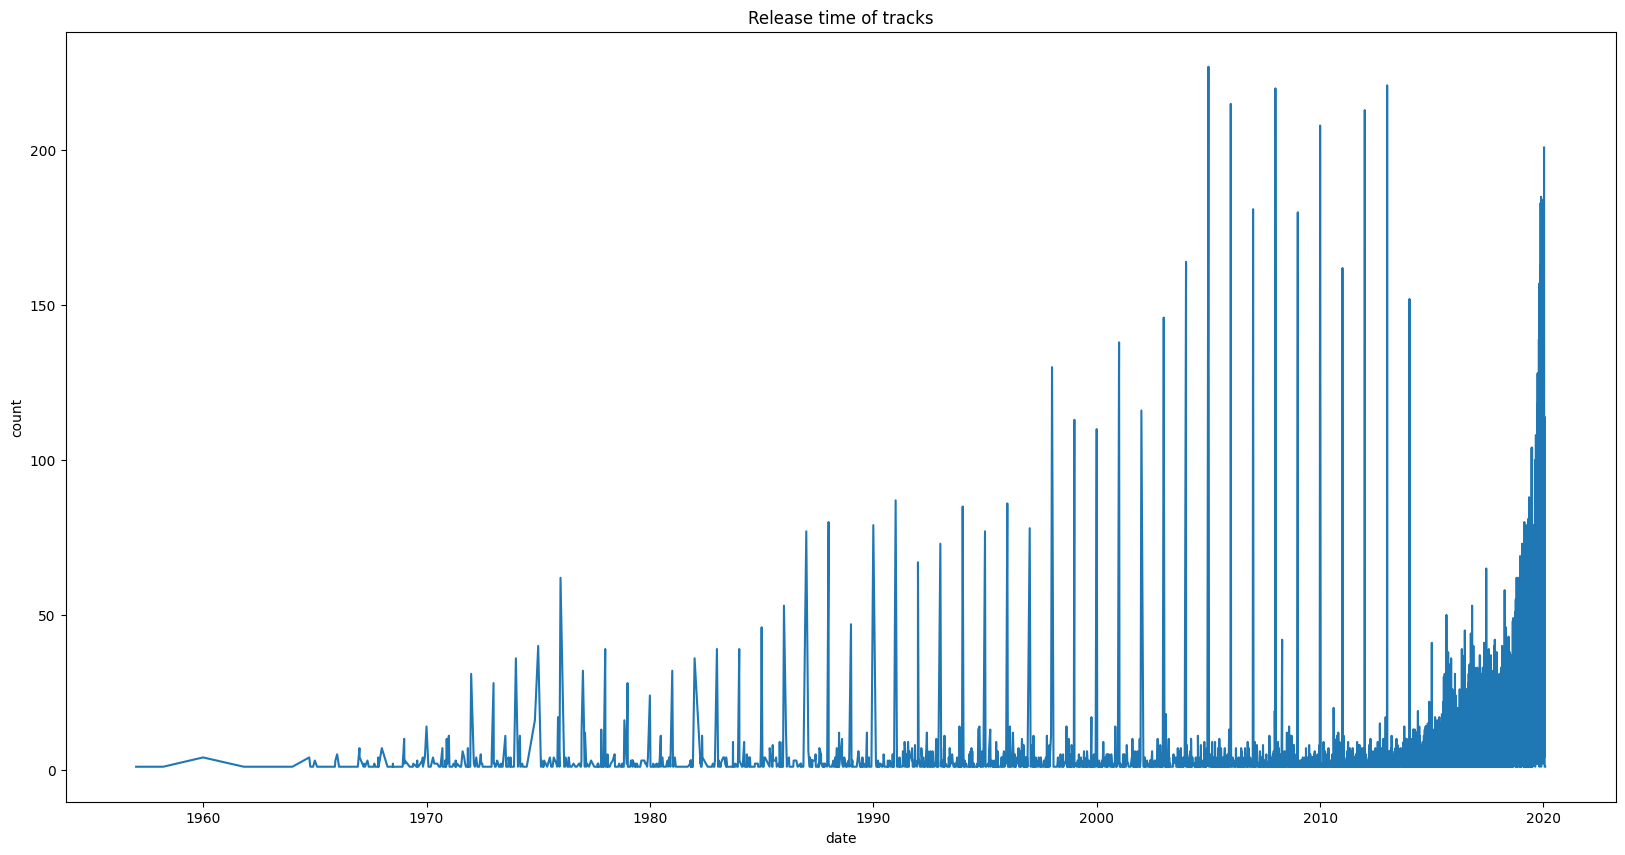

In [95]:
df_date = df_1.copy()
df_date['track_album_release_date'] = pd.to_datetime(df_date['track_album_release_date'], format="ISO8601")
date_count = pd.DataFrame(df_date['track_album_release_date'].value_counts()).reset_index()
date_count.columns = ['date', 'count']
date_count = date_count.sort_values(by = 'date', ascending=True)

fig, ax = plt.subplots( figsize=(20,10))
ax = sns.lineplot(data = date_count, x = 'date', y='count')
ax.set_title("Release time of tracks")

The timeline by single date is very dense and difficult to look for insights. Trying to replace by every month.

Text(0.5, 1.0, 'Release time of tracks')

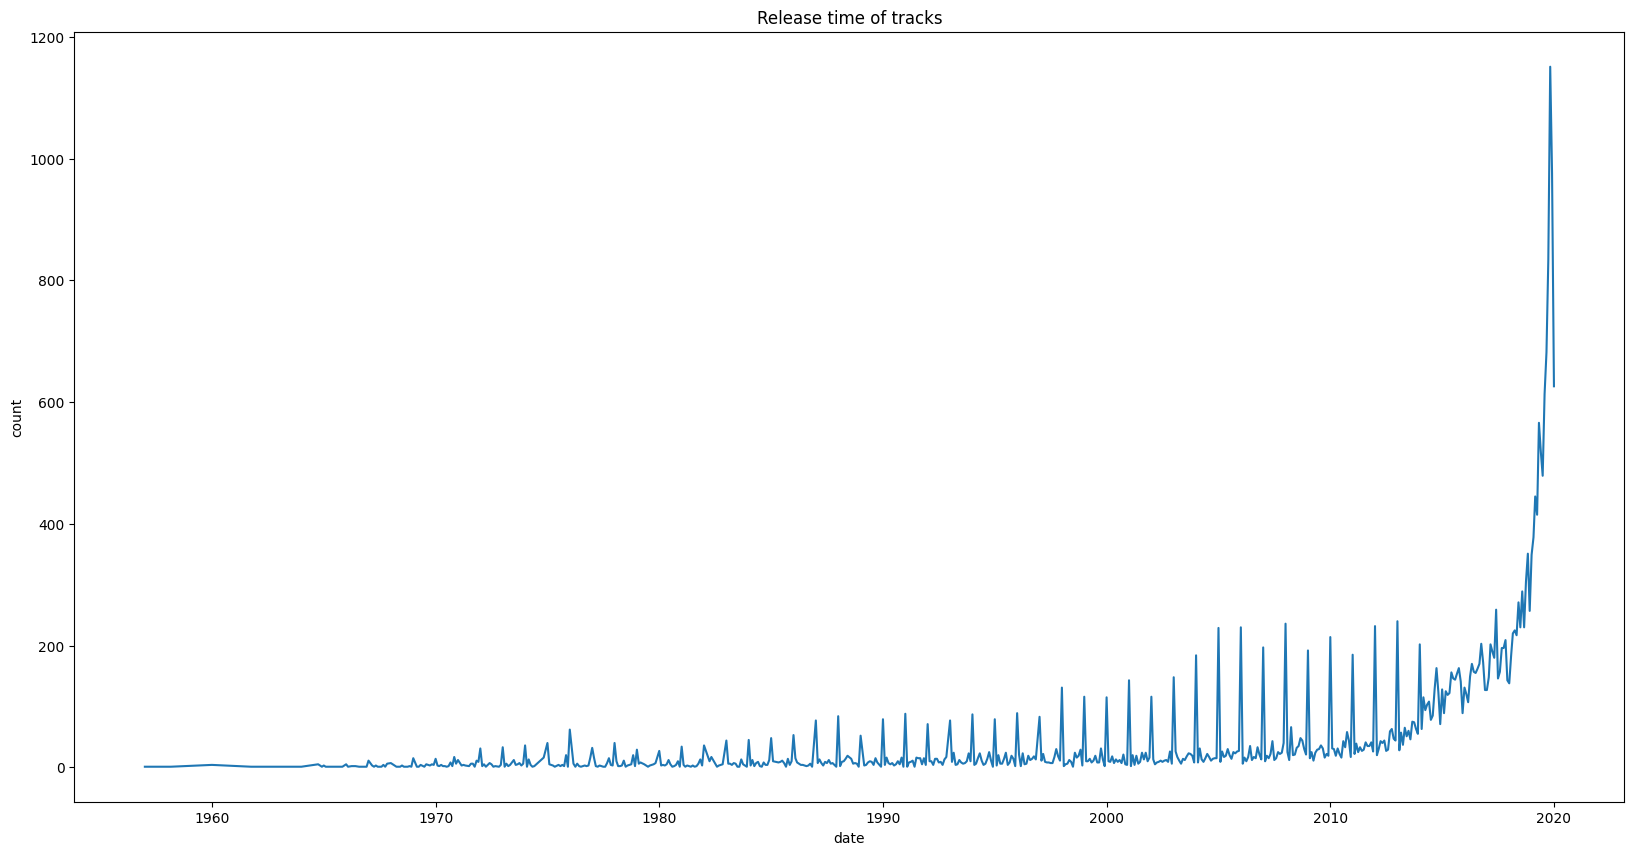

In [100]:
# Create new column with only year and month
df_date['track_album_release_year'] = df_date['track_album_release_date'].apply(lambda x: x.year)
df_date['track_album_release_month'] = df_date['track_album_release_date'].apply(lambda x: x.month)
df_date['track_album_release_YearMonth'] = df_date.apply(lambda x: str(x['track_album_release_year']) + "-" + str(x['track_album_release_month']), axis = 1)
df_date['track_album_release_YearMonth'] = pd.to_datetime(df_date['track_album_release_YearMonth'], format = "%Y-%m")


date_count = pd.DataFrame(df_date['track_album_release_YearMonth'].value_counts()).reset_index()
date_count.columns = ['date', 'count']
date_count = date_count.sort_values(by = 'date', ascending=True)

fig, ax = plt.subplots( figsize=(20,10))
ax = sns.lineplot(data = date_count, x = 'date', y='count')
ax.set_title("Release time of tracks")

* Number of collected tracks get releasing date start popularly after 1970s, and mostly from around 2013-2014.
* There are some strange moments within a year that the number of tracks suddenly released a lot. Next steps should be to check when there were.

In [103]:
df_date.loc[df_date['track_album_release_YearMonth'] <= "2010"]['track_album_release_YearMonth'].value_counts().head(15)

track_album_release_YearMonth
2008-01-01    236
2006-01-01    230
2005-01-01    229
2010-01-01    214
2007-01-01    197
2009-01-01    192
2004-01-01    184
2003-01-01    148
2001-01-01    143
1998-01-01    131
1999-01-01    116
2002-01-01    116
2000-01-01    115
1996-01-01     89
1991-01-01     88
Name: count, dtype: int64

* Those were at the beginning of year. That might be a consequence of transforming data type, as those values originally were only year. 

### About Categorical data

In [69]:
# Check Cardinality Level
cardinality = pd.DataFrame(columns = ['column_name', 'unique_values'])
for col in categorical_cols:
    unique_values = len(df_1[col].unique())
    cardinality.loc[len(cardinality)] = [col, unique_values]

for col in array_cols:
    unique_values = len(np.unique(list(itertools.chain(*df_1[col]))))
    cardinality.loc[len(cardinality)] = [col, unique_values]

cardinality

,column_name,unique_values
0,track_name,23450
1,track_artist,10693
2,track_album_id,22545
3,track_album_name,19744
4,playlist_name,449
5,playlist_subgenre,24
6,playlist_genre,6


* track_name, track_artist, track_album_id, track_album_name: High cardinality level, good to skim through a sample of top values get most count of data.
* playlist_name, playlist_genre, playlist_subgenre: Cardinality is medium and low, good to look at some descriptive analysis.

In [65]:
# Top 10 names got most tracks on Spotify
df_1['track_name'].value_counts().head(10)

track_name
Breathe     18
Paradise    17
Poison      16
Alive       15
Forever     14
Stay        14
You         13
Lost        13
Heaven      12
Changes     12
Name: count, dtype: int64

In [66]:
# Top 10 artists release most tracks on Spotify platform
df_1['track_artist'].value_counts().head(10)

track_artist
Queen                        130
Martin Garrix                 87
Don Omar                      84
David Guetta                  81
Dimitri Vegas & Like Mike     68
Drake                         68
Hardwell                      68
The Chainsmokers              66
Logic                         65
Guns N' Roses                 63
Name: count, dtype: int64

In [68]:
# Top 10 album names have most tracks on Spotify
df_1['track_album_name'].value_counts().head(10)

track_album_name
Greatest Hits                      135
Ultimate Freestyle Mega Mix         42
Gold                                34
Rock & Rios (Remastered)            29
Asian Dreamer                       20
Trip Stories                        20
Forever                             18
Malibu                              18
Los Grandes Éxitos En Español       17
Confessions of a Dangerous Mind     16
Name: count, dtype: int64

* Album Greatest Hits lead the top with 135 tracks, nearly tripple from the 2nd which is Ultimate Freestyle Mega Mix.

count    449.000000
mean      73.124722
std       36.151437
min        1.000000
25%       49.000000
50%       77.000000
75%       97.000000
max      308.000000
Name: count, dtype: float64


<Axes: >

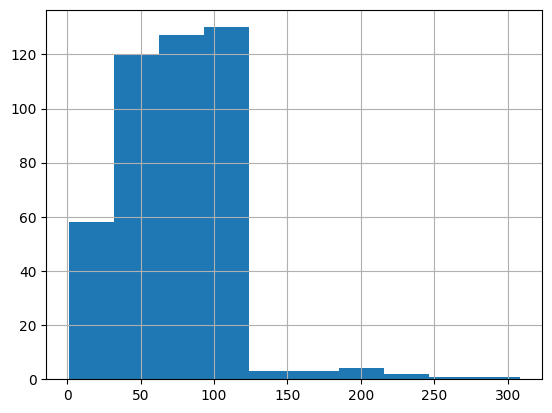

In [80]:
# With medium & low cardinality columns
playlist_df = df[['playlist_name', 'playlist_genre', 'playlist_subgenre']].reset_index(drop=True)

# How many tracks are there in a playlist, descriptively?
print(playlist_df['playlist_name'].value_counts().describe())
playlist_df['playlist_name'].value_counts().hist()

* A playlist collects averagely 73 songs, which the mostly popular range is from 49 to 97 songs.

In [82]:
# How are distributions of Genre and Sub Genre of Playlists?
unique_playlist_df = playlist_df.drop_duplicates(subset=['playlist_name'])

# Genre
unique_playlist_df['playlist_genre'].value_counts()

playlist_genre
rap      77
latin    77
edm      76
r&b      74
pop      73
rock     72
Name: count, dtype: int64

In [83]:
# Sub Genre
unique_playlist_df['playlist_subgenre'].value_counts()

playlist_subgenre
latin pop                    20
electropop                   20
big room                     20
hip hop                      20
electro house                20
neo soul                     20
trap                         20
album rock                   20
classic rock                 20
dance pop                    19
new jack swing               19
latin hip hop                19
reggaeton                    19
tropical                     19
gangster rap                 19
progressive electro house    19
hip pop                      18
southern hip hop             18
post-teen pop                17
hard rock                    17
urban contemporary           17
indie poptimism              17
pop edm                      17
permanent wave               15
Name: count, dtype: int64

* The popularity of playlist genre and subgenre is quite same to each others.

### About Numeric data

In [107]:
# Descriptive metrics
numeric_dist = df_1[numeric_cols].describe().transpose()

In [109]:
# Calculate Skewness level
"""
Skewness: 
- Formula: 3*(median - mean)/std

- Grouping:
+ A skewness value greater than 1 or less than -1 indicates a highly skewed distribution. 
+ A value between 0.5 and 1 or -0.5 and -1 is moderately skewed. 
+ A value between -0.5 and 0.5 indicates that the distribution is fairly symmetrical.
"""

numeric_dist['skewness'] = numeric_dist.apply(lambda x: round(3*(x['50%'] - x['mean'])/x['std'],2), axis = 1)

def skewness_evaluate(score):
    if score < -1:
        return "strongly right skew"
    elif (score >= -1) & (score < -0.5):
        return "moderately right skew"
    elif (score >= -0.5) & (score <= 0.5):
        return "symmetric"
    elif (score > 0.5) & (score <= 1):
        return "moderately left skew"
    elif (score > 1):
        return "strongly left skew"
    
numeric_dist['skewness_eval'] = numeric_dist['skewness'].apply(lambda x: skewness_evaluate(x))
numeric_dist

,count,mean,std,min,25%,50%,75%,max,skewness,skewness_eval
track_popularity,28356.0,39.329771,23.702376,0.000000,21.000000,42.000000,58.00000,100.000,0.34,symmetric
danceability,28356.0,0.653372,0.145785,0.000000,0.561000,0.670000,0.76000,0.983,0.34,symmetric
energy,28356.0,0.698388,0.183503,0.000175,0.579000,0.722000,0.84300,1.000,0.39,symmetric
key,28356.0,5.368000,3.613904,0.000000,2.000000,6.000000,9.00000,11.000,0.52,moderately left skew
loudness,28356.0,-6.817696,3.036243,-46.448000,-8.309250,-6.261000,-4.70900,1.275,0.55,moderately left skew
mode,28356.0,0.565489,0.495701,0.000000,0.000000,1.000000,1.00000,1.000,2.63,strongly left skew
speechiness,28356.0,0.107954,0.102556,0.000000,0.041000,0.062600,0.13300,0.918,-1.33,strongly right skew
acousticness,28356.0,0.177176,0.222803,0.000000,0.014375,0.079700,0.26000,0.994,-1.31,strongly right skew
instrumentalness,28356.0,0.091117,0.232548,0.000000,0.000000,0.000021,0.00657,0.994,-1.18,strongly right skew
liveness,28356.0,0.190958,0.155894,0.000000,0.092600,0.127000,0.24900,0.996,-1.23,strongly right skew


Index(['track_id', 'track_name', 'track_artist', 'track_popularity',
       'track_album_id', 'track_album_name', 'track_album_release_date',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'playlist_name', 'playlist_subgenre', 'playlist_genre'],
      dtype='object')

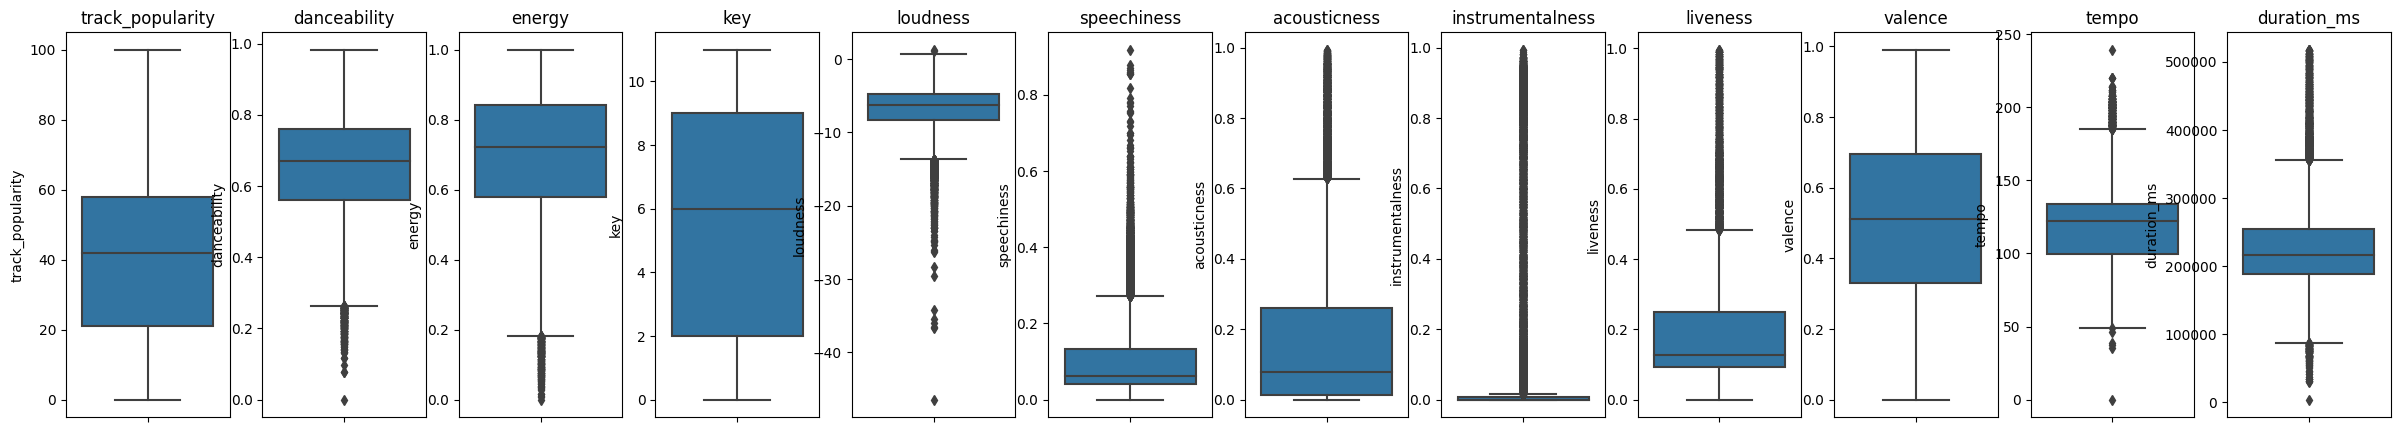

In [178]:
# Botplot of distribution
fig, ax = plt.subplots(1, len(numeric_cols), figsize=(30, 5))
i = 0
for col in numeric_cols:
    sns.boxplot(data = df_1, y = col, ax = ax[i])
    ax[i].set_title(col, loc= 'center')
    i += 1

In [116]:
df_1['mode'].value_counts()

mode
1    16035
0    12321
Name: count, dtype: int64

* Valence has the most symmetrical form, following is tempo.
* Strong skewnesses comes from speechiness, acousticness, liveness, instrumentalness respectively. All of these skewing form are right.
* Mode is binary data with unique values are 0 and 1 --> Not be considered as a continuous variable.
* Track popularity get quite normal distribution with most common value (median) at 42 scores.


## 2.2. Bivariate Analysis

In [120]:
categorical_cols = ['playlist_genre', 'playlist_subgenre']
numeric_cols

['playlist_name', 'playlist_subgenre', 'playlist_genre']

### Regression Analysis among Numeric Variables

<Axes: >

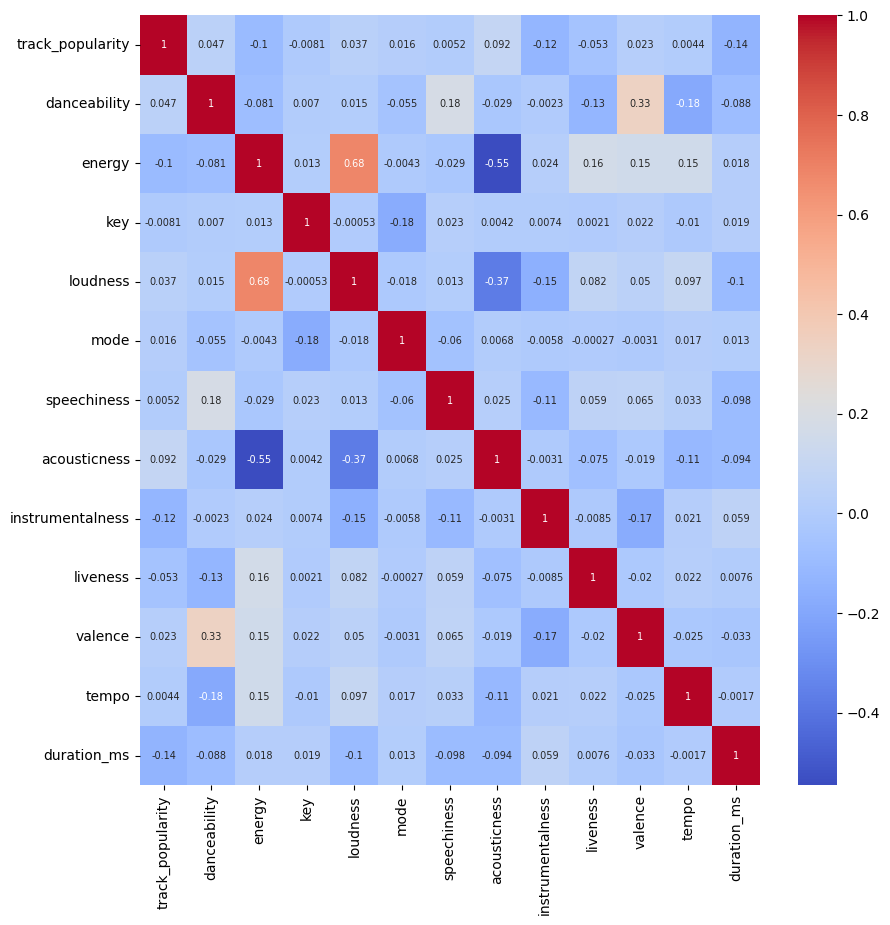

In [128]:
# Evaluate Correlation Coefficients
fig, ax = plt.subplots(1,1,figsize=(10, 10))
sns.heatmap(df_1[numeric_cols].corr(method='pearson'), 
            xticklabels=df_1[numeric_cols].corr().columns.values,
            yticklabels=df_1[numeric_cols].corr().columns.values, 
            annot = True,
            cmap = 'coolwarm',
            annot_kws={'size': 7}
           )

In [141]:
# Correlation score table
numeric_corr = df_1[numeric_cols].corr().unstack().reset_index()
numeric_corr.columns = ['var1', 'var2', 'corr_coef'] 
numeric_corr['vars'] = numeric_corr.apply(lambda x: sorted([x['var1'], x['var2']]), axis = 1)
numeric_corr = numeric_corr.loc[numeric_corr['corr_coef'] != 1].drop_duplicates(subset='vars')
numeric_corr['corr_coef_abs'] = numeric_corr['corr_coef'].apply(lambda x: abs(x))
numeric_corr['corr_type'] = numeric_corr['corr_coef'].apply(lambda x: 'positive' if x > 0 else 'negative')
numeric_corr = numeric_corr.sort_values(by = 'corr_coef_abs', ascending=False)
numeric_corr.loc[numeric_corr['corr_coef_abs'] >= 0.3]

,var1,var2,corr_coef,vars,corr_coef_abs,corr_type
30,energy,loudness,0.682138,"[energy, loudness]",0.682138,positive
33,energy,acousticness,-0.545886,"[acousticness, energy]",0.545886,negative
59,loudness,acousticness,-0.371602,"[acousticness, loudness]",0.371602,negative
23,danceability,valence,0.333729,"[danceability, valence]",0.333729,positive


**Insights:**

Strong Correlation (|r| >= 0.5):
- Energy vs. Loudness, positively
- Energy vs. Acousticness, negatively

Moderate Correlation (|r| < 0.5):
- Loudness vs. Acousticness, negatively
- Valence vs. danceability, positively

None of features is strong correlation with track_popularity. The highest corr among them is from instrumentalness, duration_ms and energy (all negative).

### Distribution of numeric variables , divided by categorical variables

In [157]:
df.groupby('playlist_genre').agg({'loudness': ['mean', 'std']})

loudness          
                    mean       std
playlist_genre                    
edm            -5.427445  2.371431
latin          -6.264455  2.865150
pop            -6.315328  2.622209
r&b            -7.864848  2.891189
rap            -7.042269  3.054460
rock           -7.588895  3.380225

In [168]:
numeric_cols = [col for col in numeric_cols if col != 'mode']

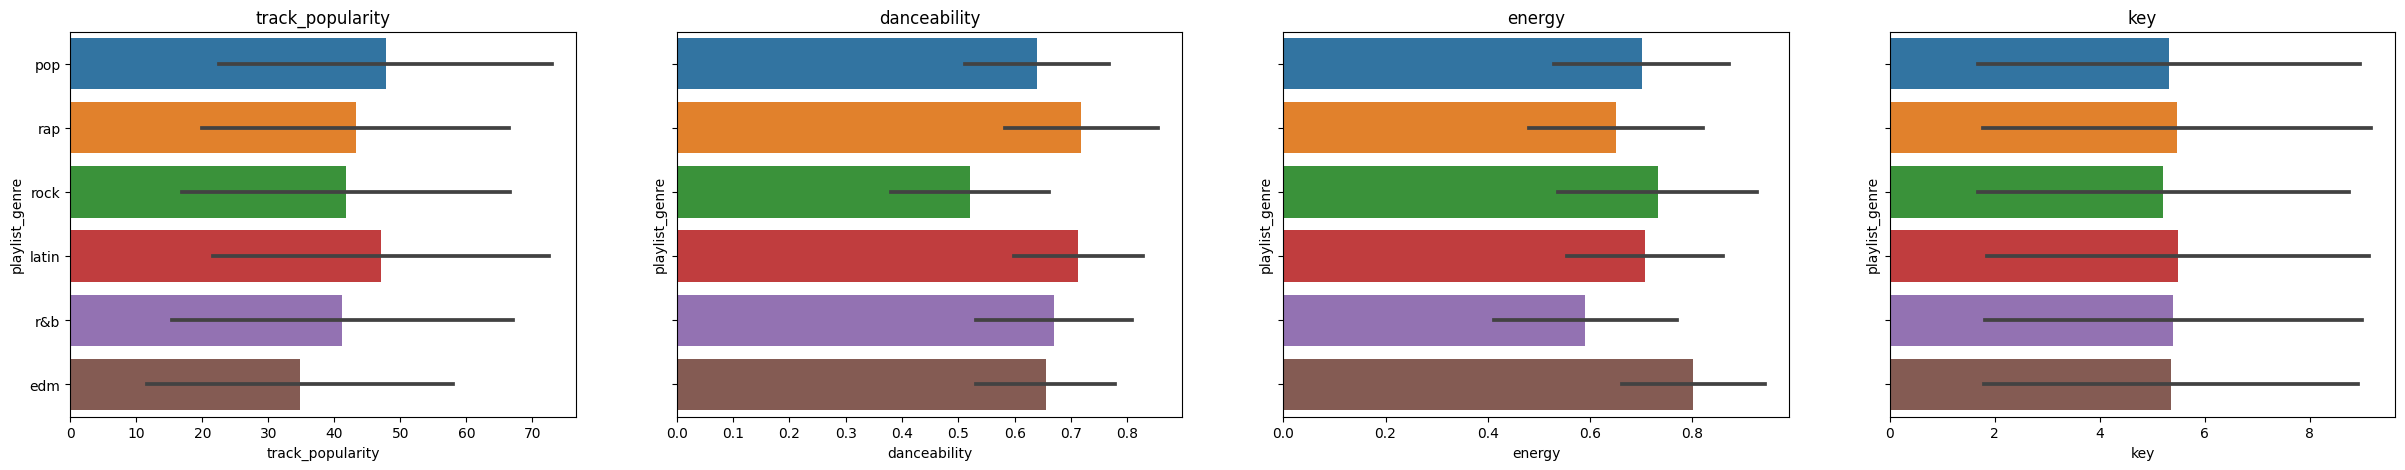

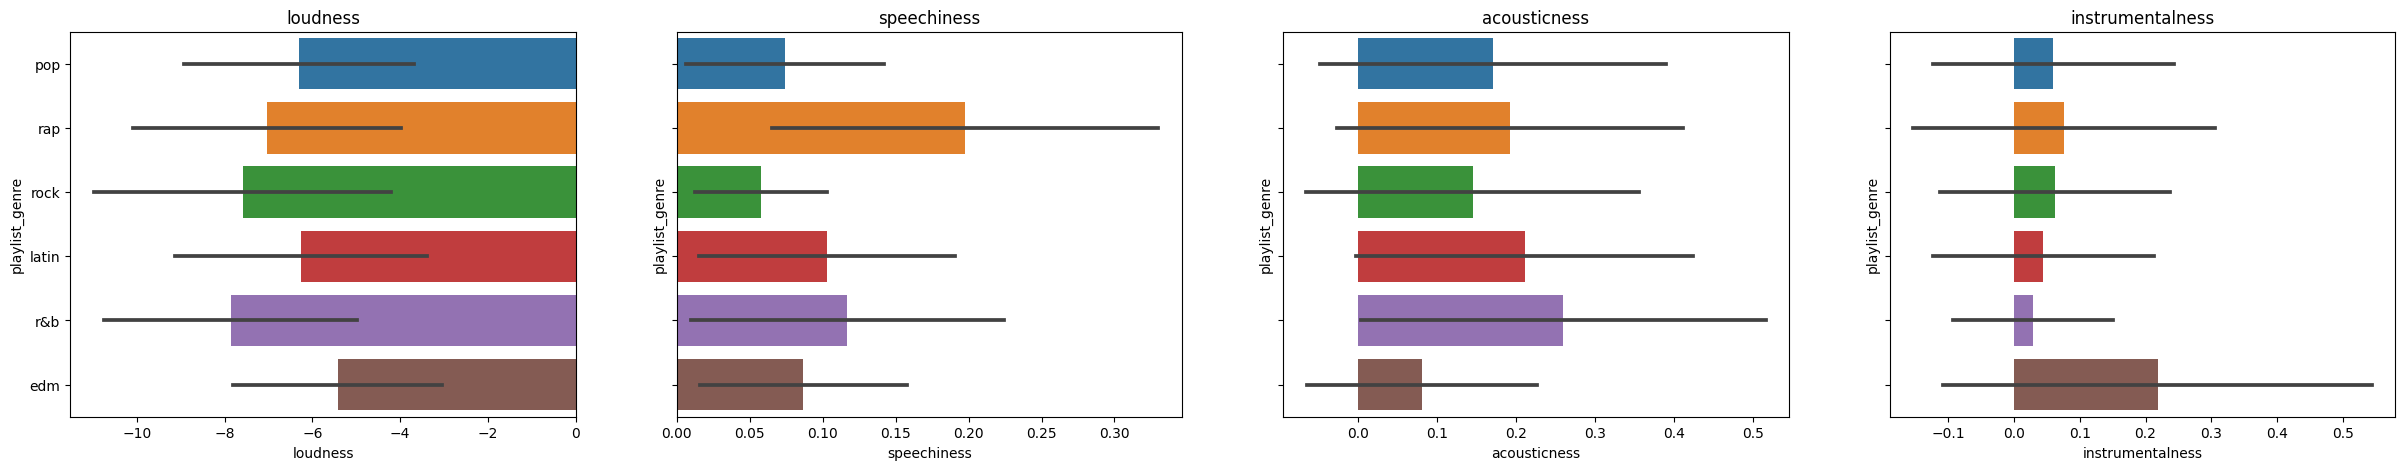

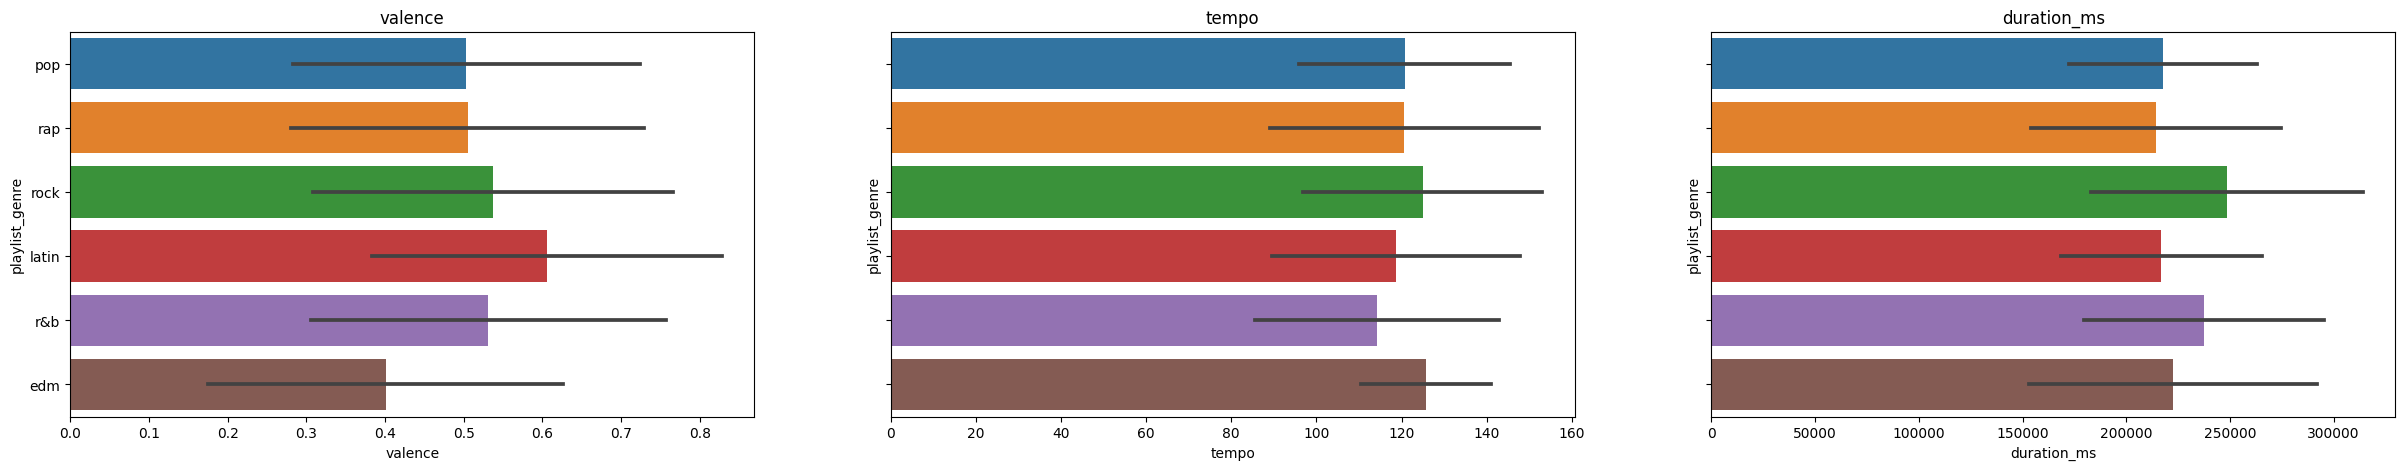

In [174]:
# Part 1
fig, ax = plt.subplots(1, len(numeric_cols[0:4]), figsize=(30,5), sharey=True)
i = 0
for col in numeric_cols[0:4]:
    sns.barplot(data = df, y = 'playlist_genre', x = col, errorbar='sd', ax = ax[i])
    ax[i].set_title(col)
    i += 1

# Part 2
fig, ax = plt.subplots(1, len(numeric_cols[4:8]), figsize=(30,5), sharey=True)
i = 0
for col in numeric_cols[4:8]:
    sns.barplot(data = df, y = 'playlist_genre', x = col, errorbar='sd', ax = ax[i])
    ax[i].set_title(col)
    i += 1

# Part 3
fig, ax = plt.subplots(1, len(numeric_cols[9:]), figsize=(30,5), sharey=True)
i = 0
for col in numeric_cols[9:]:
    sns.barplot(data = df, y = 'playlist_genre', x = col, errorbar='sd', ax = ax[i])
    ax[i].set_title(col)
    i += 1

* Rap get significant highest speechiness among genres; its variety is large as well.
* Danceability of rock is lower than rest of genres.
* Highest distance of instrumentalness all come from EDM. EDM also has the lowest valence score in terms of mean, and highest mean of energy, but not clear.

In [183]:
df[['playlist_subgenre', 'energy']]

,playlist_subgenre,energy
0,dance pop,0.916
1,dance pop,0.815
2,dance pop,0.931
3,dance pop,0.930
4,dance pop,0.833
...,...,...
32828,progressive electro house,0.922
32829,progressive electro house,0.786
32830,progressive electro house,0.821
32831,progressive electro house,0.888


In [184]:
d = pd.DataFrame(dict(
    r=[1, 5, 2, 2, 3],
    theta=['processing cost','mechanical properties','chemical stability',
           'thermal stability', 'device integration']))
d

,r,theta
0,1,processing cost
1,5,mechanical properties
2,2,chemical stability
3,2,thermal stability
4,3,device integration


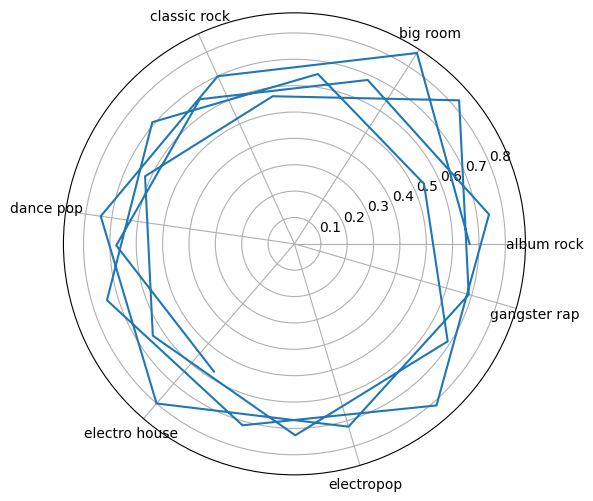

In [188]:
fig=plt.figure(figsize=(6,6))
ax=fig.add_subplot(polar=True)
ax.plot(subgenre_count['playlist_subgenre'],subgenre_count['energy'])
plt.show()

In [187]:
# Sub genre
import plotly.express as px
subgenre_count = df.groupby('playlist_subgenre').agg({'energy': 'mean'}).reset_index()
subgenre_count

# fig = px.line_polar(df, r='energy', theta='playlist_subgenre', line_close=True)
# fig.update_traces(fill='toself')
# fig.show()

,playlist_subgenre,energy
0,album rock,0.664189
1,big room,0.860316
2,classic rock,0.699240
3,dance pop,0.742189
4,electro house,0.800044
5,electropop,0.723269
6,gangster rap,0.688549
7,hard rock,0.828541
8,hip hop,0.565940
9,hip pop,0.621870


In [ ]:
# Part 3

* Most popular score of **Pop** is the highest compare to the same point of other genres. Following is **Latin**.
* Most tracks in **EDM** genres got nearly 40 score of popularity. It also got most number of tracks with 0 score. 

In [27]:
# What are subgenres of those playlists of a track?
df_train['playlist_subgenre_count'] = df_train['playlist_subgenre'].apply(lambda x: len(set(x)))
subgenre_unique_values = list(pd.Series(itertools.chain.from_iterable(df_train['playlist_subgenre'].values)).value_counts().keys())
subgenre_unique_values

['progressive electro house',
 'southern hip hop',
 'indie poptimism',
 'latin hip hop',
 'neo soul',
 'pop edm',
 'electro house',
 'hard rock',
 'gangster rap',
 'electropop',
 'urban contemporary',
 'hip hop',
 'trap',
 'dance pop',
 'tropical',
 'classic rock',
 'hip pop',
 'latin pop',
 'new jack swing',
 'big room',
 'post-teen pop',
 'permanent wave',
 'album rock',
 'reggaeton']

,subgenre,mean,median
20,post-teen pop,56.458836,64.0
21,permanent wave,54.114548,59.0
11,hip hop,53.891993,56.0
16,hip pop,53.634366,60.0
23,reggaeton,52.956693,59.0
13,dance pop,52.570342,56.0
17,latin pop,51.381433,54.0
10,urban contemporary,50.783333,55.5
12,trap,50.584834,54.0
5,pop edm,45.418699,46.0


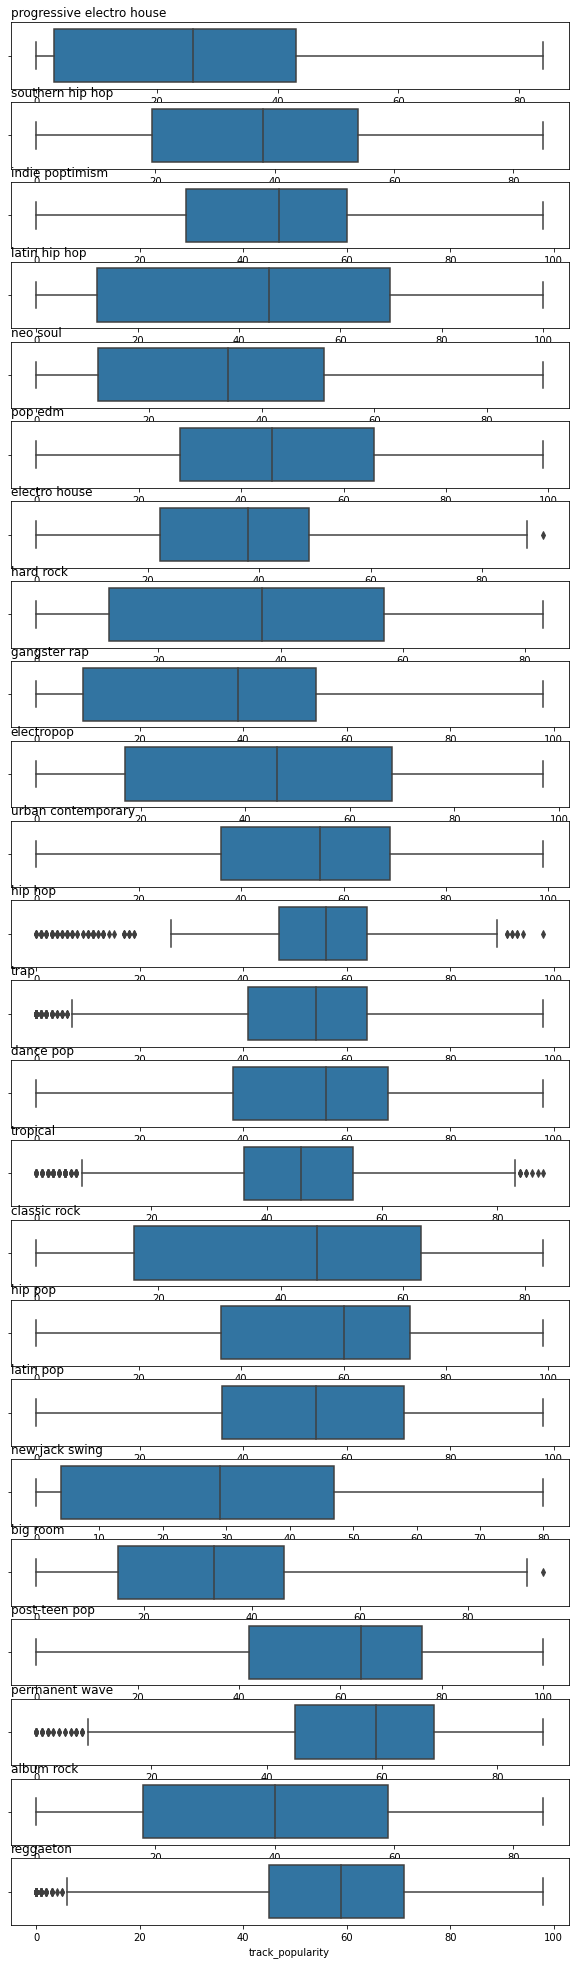

In [28]:
fig, ax = plt.subplots(len(subgenre_unique_values), 1, figsize = (10,35))

def find_subgenre(word_need_find, subgenres):
    if word_need_find in subgenres:
        return 1
    else:
        return 0
    
pop_scores_by_subgenre = pd.DataFrame(columns =['subgenre', 'mean', 'median'])
i = 0
for subgenre in subgenre_unique_values:
    df_train_temp = df_train.copy()
    df_train_temp[subgenre] = df_train['playlist_subgenre'].apply(lambda x: find_subgenre(subgenre, x))
    mean = df_train_temp.loc[df_train_temp[subgenre] == 1]['track_popularity'].describe()['mean']
    median = df_train_temp.loc[df_train_temp[subgenre] == 1]['track_popularity'].describe()['50%']
    new = pd.Series({
        'subgenre': subgenre,
        'mean': mean,
        'median': median
    })
    pop_scores_by_subgenre = pop_scores_by_subgenre.append(new, ignore_index = True)
    sns.boxplot(data = df_train_temp.loc[df_train_temp[subgenre] == 1], x = 'track_popularity', ax = ax[i])
    ax[i].set_title(subgenre, loc = 'left')
    i += 1
    
pop_scores_by_subgenre.sort_values(by = 'mean', ascending=False)

There are some big different between some subgenres, for ex: new jack swing and permanent wave. **How process next?**

In [29]:
df_train.columns

Index(['track_id', 'track_name', 'track_artist', 'track_popularity',
       'track_album_id', 'track_album_name', 'track_album_release_date',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'playlist_name', 'playlist_subgenre', 'playlist_genre',
       'track_album_release_year', 'track_album_release_month',
       'track_album_release_day', 'playlist_contain_count',
       'playlist_genre_count', 'playlist_genre_edm', 'playlist_genre_rap',
       'playlist_genre_pop', 'playlist_genre_r&b', 'playlist_genre_latin',
       'playlist_genre_rock', 'playlist_subgenre_count'],
      dtype='object')

In [30]:
# Correlation between number of playlist, genre and subgenre of song with its popularity
df_train[['playlist_contain_count', 'playlist_genre_count', 'playlist_subgenre_count', 'track_popularity']].corr()

,playlist_contain_count,playlist_genre_count,playlist_subgenre_count,track_popularity
playlist_contain_count,1.000000,0.768548,0.958973,0.292735
playlist_genre_count,0.768548,1.000000,0.810860,0.245281
playlist_subgenre_count,0.958973,0.810860,1.000000,0.282617
track_popularity,0.292735,0.245281,0.282617,1.000000


If the track has high popularity score, it high chance to be chosen in many playlists.

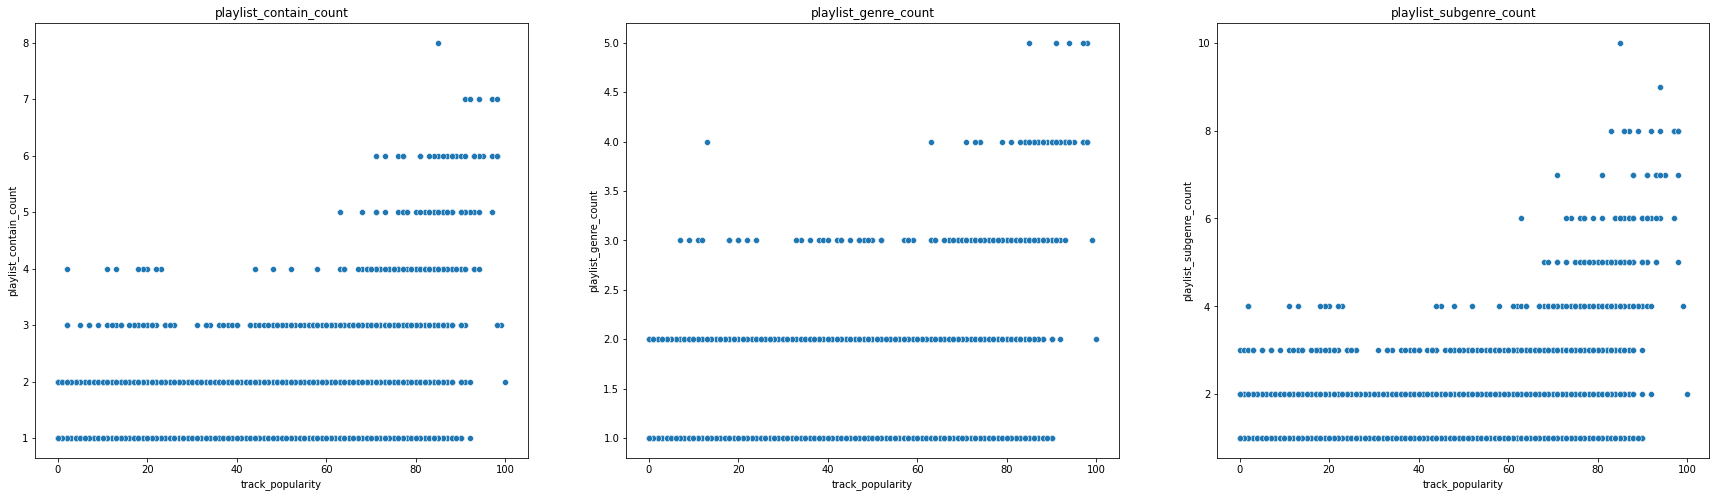

In [31]:
fig, ax = plt.subplots(1, 3, figsize = (30,8))
i = 0
for metric in ['playlist_contain_count', 'playlist_genre_count', 'playlist_subgenre_count']:
    sns.scatterplot(data = df_train, x = 'track_popularity', y = metric, ax = ax[i])
    ax[i].set_title(metric)
    i += 1

* The positive correlation with track popularity only starts strongly if the count is from 4 upto.

## 3. Soundtrack Indicators Analysis

### 3.1. Variable Distribution

In [32]:
sound_indicator_cols = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

print("Number of sound indicators:", len(sound_indicator_cols))

Number of sound indicators: 11


In [33]:
sound_index_desc = df_train[sound_indicator_cols].describe().transpose()

"""
Skewness: 
- Formula: 3*(median - mean)/std

- Grouping:
+ A skewness value greater than 1 or less than -1 indicates a highly skewed distribution. 
+ A value between 0.5 and 1 or -0.5 and -1 is moderately skewed. 
+ A value between -0.5 and 0.5 indicates that the distribution is fairly symmetrical.
"""

sound_index_desc['skewness'] = sound_index_desc.apply(lambda x: round(3*(x['50%'] - x['mean'])/x['std'],2), axis = 1)

def skewness_evaluate(score):
    if score < -1:
        return "strongly right skew"
    elif (score >= -1) & (score < -0.5):
        return "moderately right skew"
    elif (score >= -0.5) & (score <= 0.5):
        return "symmetric"
    elif (score > 0.5) & (score <= 1):
        return "moderately left skew"
    elif (score > 1):
        return "strongly left skew"
    
sound_index_desc['skewness_eval'] = sound_index_desc['skewness'].apply(lambda x: skewness_evaluate(x))
sound_index_desc

,count,mean,std,min,25%,50%,75%,max,skewness,skewness_eval
danceability,22685.0,0.653611,0.145736,0.000000,0.5610,0.67000,0.7600,0.983,0.34,symmetric
energy,22685.0,0.698080,0.183589,0.000175,0.5800,0.72200,0.8430,1.000,0.39,symmetric
key,22685.0,5.350364,3.612656,0.000000,2.0000,6.00000,9.0000,11.000,0.54,moderately left skew
loudness,22685.0,-6.821016,3.043993,-46.448000,-8.3170,-6.26300,-4.7090,1.275,0.55,moderately left skew
mode,22685.0,0.564558,0.495826,0.000000,0.0000,1.00000,1.0000,1.000,2.63,strongly left skew
speechiness,22685.0,0.108460,0.102919,0.000000,0.0410,0.06300,0.1340,0.918,-1.33,strongly right skew
acousticness,22685.0,0.178159,0.223748,0.000000,0.0146,0.08040,0.2610,0.994,-1.31,strongly right skew
instrumentalness,22685.0,0.091345,0.233270,0.000000,0.0000,0.00002,0.0065,0.994,-1.17,strongly right skew
liveness,22685.0,0.190709,0.155272,0.000000,0.0925,0.12700,0.2490,0.996,-1.23,strongly right skew
valence,22685.0,0.511580,0.234398,0.000000,0.3300,0.51500,0.6950,0.990,0.04,symmetric


- The Loudness got both positive and negative values
- Tempo and Loudness get the most different descriptive values while other features have same with each others.

**Consideration:** Conduct features normalization if need.

IndexError: index 11 is out of bounds for axis 0 with size 11

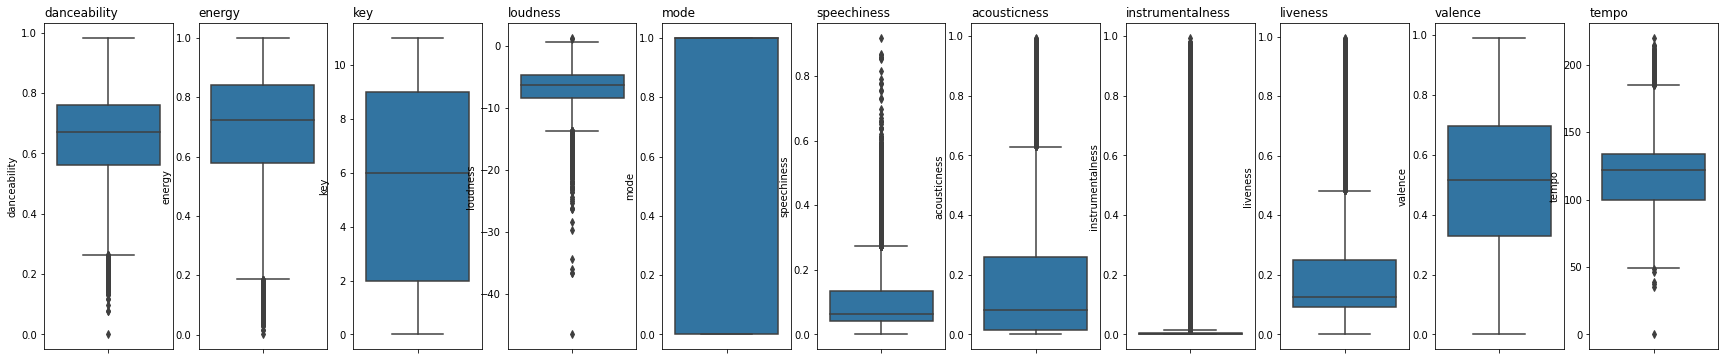

In [52]:
# double check with chart
fig, axes = plt.subplots( 1, len(sound_indicator_cols), figsize=(30,6))
for i in range(0, len(sound_indicator_cols) + 1):
    sns.boxplot(ax = axes[i], data = df_train, y = sound_indicator_cols[i])
    axes[i].set_title(sound_indicator_cols[i], loc='left')

### Bivariate Analysis

One of attributes for creating Popularity Index is how many times that tracks streamed recently, so a new column about release_days should be conducted, assume the latest release date in the dataset is today at that time.

In [75]:
today = df_train.sort_values(by = 'track_album_release_date', ascending=False)['track_album_release_date'].values[0]

df_train['release_days'] = df_train['track_album_release_date'].apply(lambda x: (today - x).days)

In [76]:
numeric_cols = ['track_popularity',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'track_album_release_year', 'track_album_release_month','track_album_release_day',
       'release_days']

<AxesSubplot:>

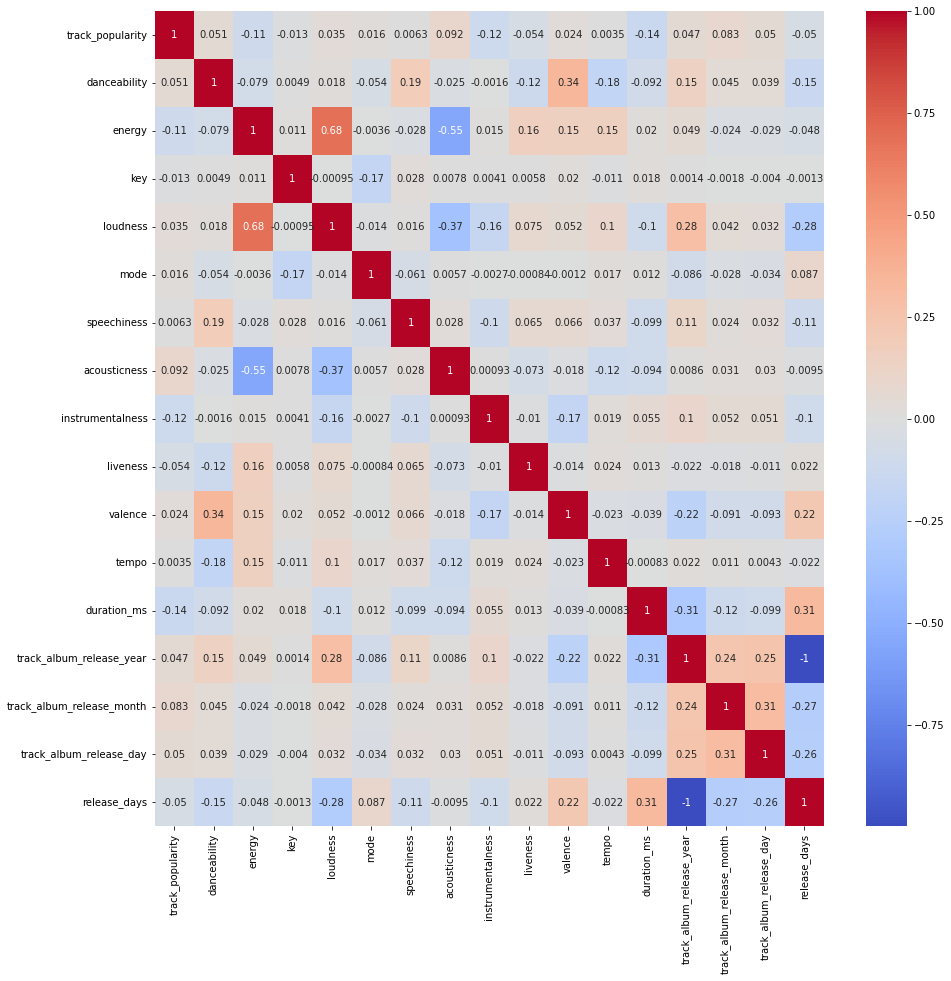

In [77]:
fig, ax = plt.subplots(1,1,figsize=(15, 15))
sns.heatmap(df_train[numeric_cols].corr(method='pearson'), 
            xticklabels=df_train[numeric_cols].corr().columns.values,
            yticklabels=df_train[numeric_cols].corr().columns.values, 
            annot = True,
            cmap = 'coolwarm'
           )

**Insights:**

Strong Correlation (|r| >= 0.5):
- Energy vs. Loudness, positively
- Energy vs. Acousticness, negatively

Moderate Correlation (|r| < 0.5):

- Valence vs. danceability, positively
- Loudness vs. track_year, positively
- Duration vs. release_days, negtively

- Loudness vs. Acousticness, negatively
- Loudness vs. release_days, negatively

None of features is strong correlation with track_popularity. The highest corr among them is from instrumentalness, duration_ms and energy (all negative).

In [78]:
correlated_cols = ['track_popularity',
       'energy', 'loudness',
       'acousticness', 'instrumentalness', 'valence', 
       'duration_ms', 'track_album_release_year','release_days']

sound_index_desc.filter(items = correlated_cols, axis=0)

,count,mean,std,min,25%,50%,75%,max,skewness,skewness_eval
energy,22685.0,0.698080,0.183589,0.000175,0.5800,0.72200,0.8430,1.000,0.39,symmetric
loudness,22685.0,-6.821016,3.043993,-46.448000,-8.3170,-6.26300,-4.7090,1.275,0.55,moderately left skew
acousticness,22685.0,0.178159,0.223748,0.000000,0.0146,0.08040,0.2610,0.994,-1.31,strongly right skew
instrumentalness,22685.0,0.091345,0.233270,0.000000,0.0000,0.00002,0.0065,0.994,-1.17,strongly right skew
valence,22685.0,0.511580,0.234398,0.000000,0.3300,0.51500,0.6950,0.990,0.04,symmetric


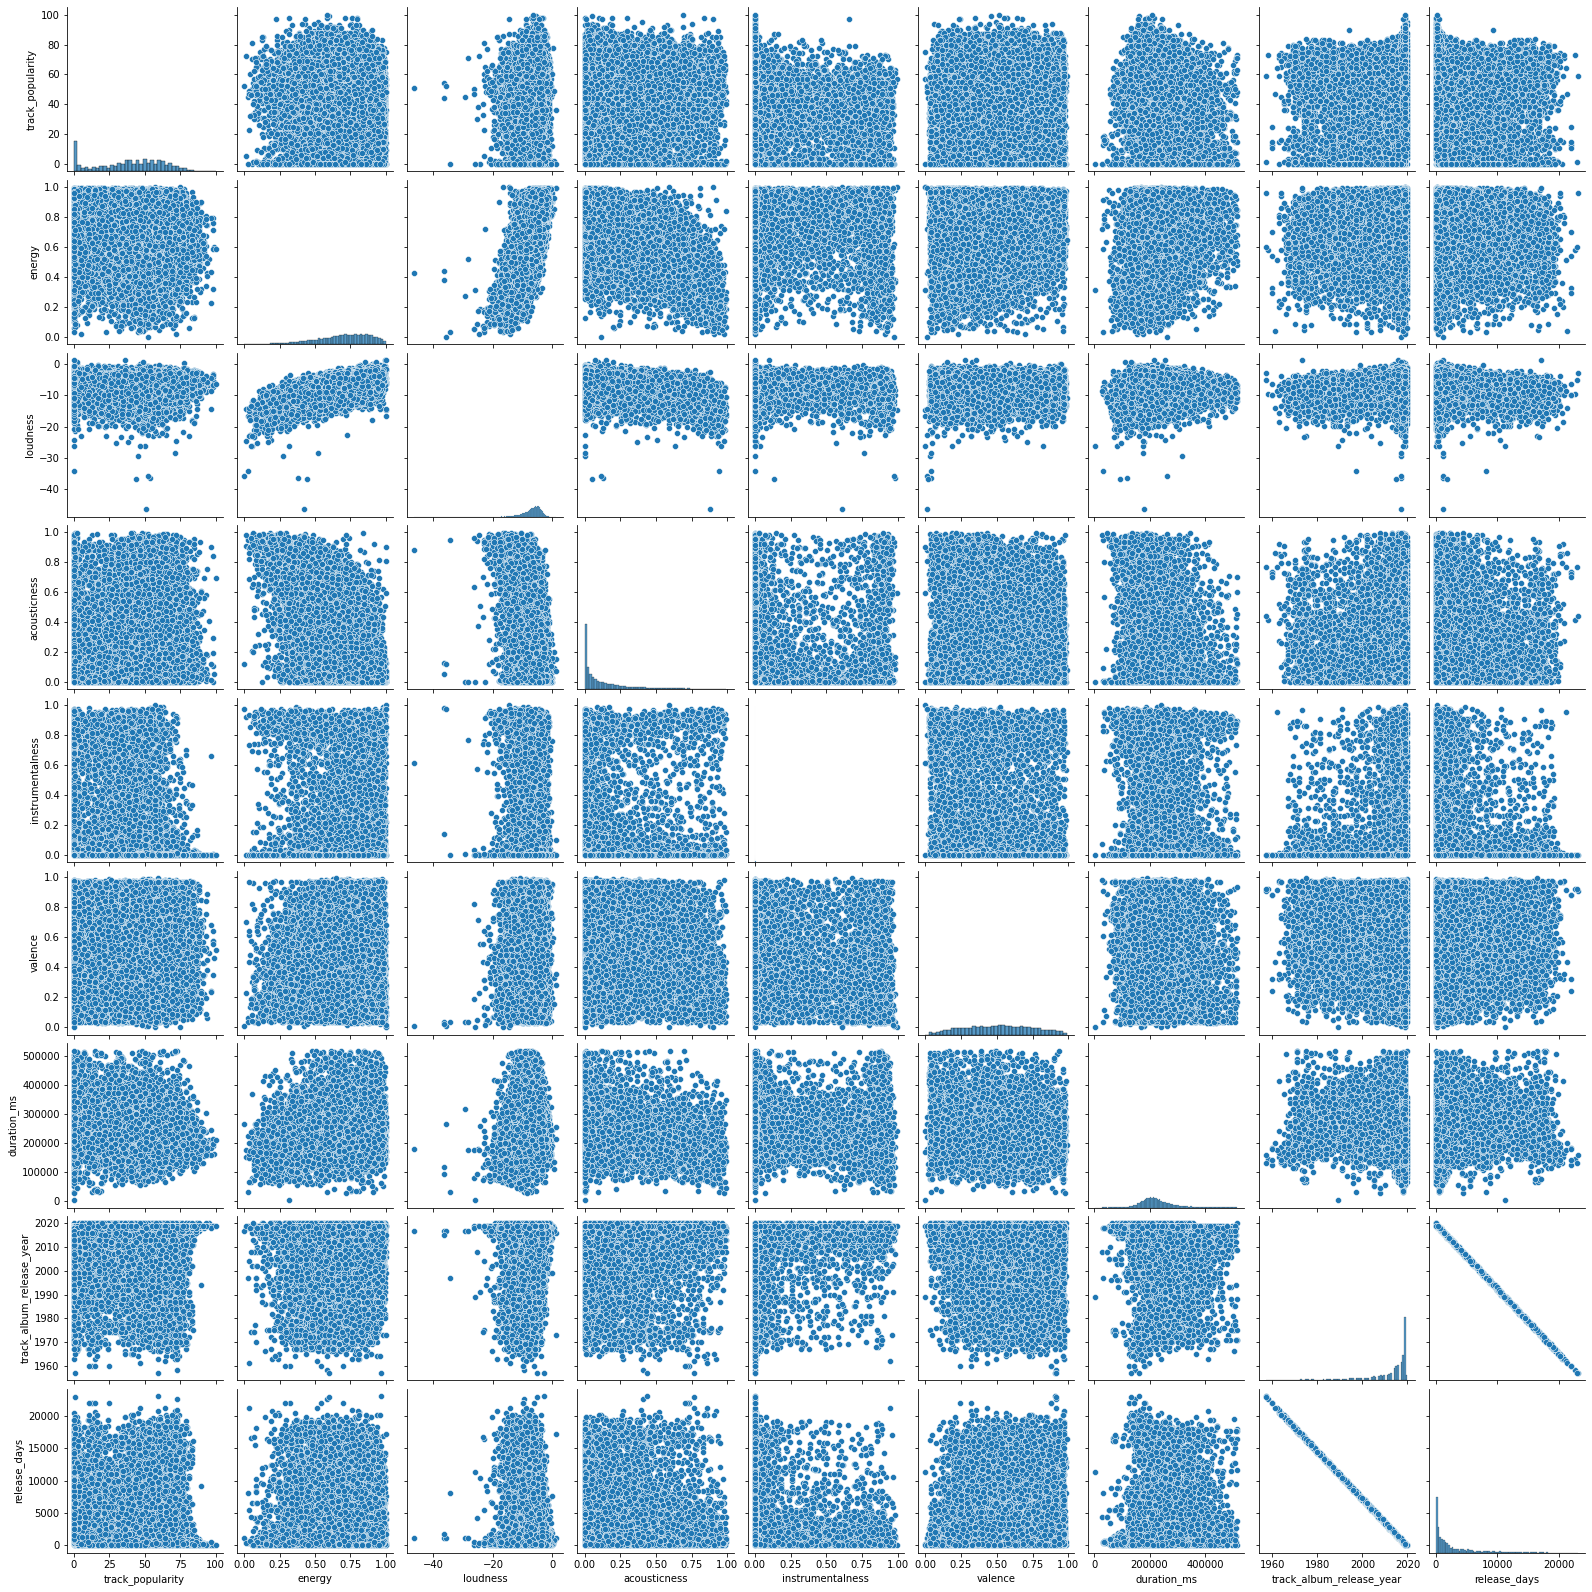

In [79]:
# fig, ax = plt.subplots(1,1,figsize=(15, 15))
sns.pairplot(df_train[correlated_cols])

# 4. Model Building (Classification)

In [80]:
# libraries
from sklearn import model_selection

# Algorithm
import xgboost
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
algos = [XGBClassifier(random_state = 2), RandomForestClassifier(random_state = 2)]
algos_name = ['XGBoost', 'RandomForest']

from sklearn import metrics

## 4.0. Class label 

In [81]:
# Class label
first_label_threshold = 50
def label_pop(score):
    if score < first_label_threshold:
        return "not popular"
    elif score >= first_label_threshold:
        return "popular"
df_train['popularity_label'] = df_train['track_popularity'].apply(lambda x: label_pop(x)) 
df_test['popularity_label'] = df_test['track_popularity'].apply(lambda x: label_pop(x)) 

In [82]:
# label ratio
print(df_train['popularity_label'].value_counts()/df_train['popularity_label'].value_counts().sum())
print("\nBaseline of result is:", round((df_train['popularity_label'].value_counts()/df_train['popularity_label'].value_counts().sum())['not popular'], 2))

not popular    0.611902
popular        0.388098
Name: popularity_label, dtype: float64

Baseline of result is: 0.61


### Model 1: without features engineer

In [83]:
df_train.columns

Index(['track_id', 'track_name', 'track_artist', 'track_popularity',
       'track_album_id', 'track_album_name', 'track_album_release_date',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'playlist_name', 'playlist_subgenre', 'playlist_genre',
       'track_album_release_year', 'track_album_release_month',
       'track_album_release_day', 'playlist_contain_count',
       'playlist_genre_count', 'playlist_genre_edm', 'playlist_genre_rap',
       'playlist_genre_pop', 'playlist_genre_r&b', 'playlist_genre_latin',
       'playlist_genre_rock', 'playlist_subgenre_count', 'release_days',
       'popularity_label'],
      dtype='object')

In [84]:
original_features = [
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'popularity_label']
df_train_0 = df_train[original_features]
print("Number of features, not including class:", len(df_train_0.columns) - 1)

Number of features, not including class: 12


In [85]:
# encoding categorical cols
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
encoder.fit(df_train_0['popularity_label'])
df_train_0['popularity_label'] = encoder.transform(df_train_0['popularity_label'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [86]:
# Label dictionary, orderly with 0,1,2
encoder.classes_

array(['not popular', 'popular'], dtype=object)

In [87]:
df_train_0.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,popularity_label
0,0.770,0.792,3,-2.931,0,0.1750,0.0698,0.00000,0.0981,0.182,100.075,236388,1
1,0.466,0.747,4,-4.838,0,0.0795,0.4170,0.00001,0.1070,0.430,92.161,203641,1
2,0.823,0.457,0,-7.036,0,0.1190,0.2140,0.00000,0.3520,0.268,115.991,315847,1
3,0.852,0.773,10,-6.474,0,0.0557,0.2160,0.00201,0.0948,0.860,116.438,249600,0
4,0.486,0.713,2,-3.949,0,0.0524,0.0853,0.00000,0.0839,0.297,121.028,226720,0


In [88]:
# Prepare test set
df_test_0 = df_test[original_features]
df_test_0['popularity_label'] = encoder.transform(df_test_0['popularity_label'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [89]:
algos

[XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, gamma=None,
               gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, n_estimators=100, n_jobs=None,
               num_parallel_tree=None, predictor=None, random_state=2,
               reg_alpha=None, reg_lambda=None, ...),
 RandomForestClassifier(random_state=2)]

In [90]:
# Set up
result_0 = pd.DataFrame(columns = ['algo', 'accuracy', 'recall', 'precision', 'tp', 'fn', 'fp', 'tn'])
i = 0
for algo in algos:
    training = model_selection.cross_validate(
                                    algo, 
                                    df_train_0.loc[:, df_train_0.columns != 'popularity_label'], 
                                    df_train_0['popularity_label'],
                                    cv=5,
                                    scoring = ['accuracy', 'recall', 'precision', 'roc_auc'],
                                    return_estimator = True
                                    )

    best_model = training['estimator'][training['test_roc_auc'].argmax()]
    y_pred = best_model.predict(df_test_0.loc[:, df_test_0.columns != 'popularity_label'])
    y_true = df_test_0['popularity_label']
    accuracy = metrics.accuracy_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred, pos_label = 1)
    precision = metrics.precision_score(y_true, y_pred, pos_label = 1)
    tp, fn, fp, tn = metrics.confusion_matrix(y_true, y_pred,  labels = [1,0]).ravel()

    new_result = pd.Series({
        'algo': algos_name[i],
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision,
        'tp': tp,
        'fn': fn, 
        'fp': fp, 
        'tn': tn
    })

    result_0 = result_0.append(new_result, ignore_index=True)
    i += 1

In [91]:
result_0

,algo,accuracy,recall,precision,tp,fn,fp,tn
0,XGBoost,0.619467,0.352022,0.505945,766,1410,748,2747
1,RandomForest,0.629871,0.302390,0.531073,658,1518,581,2914


### Model 2: Features engineer

**Strategy for model 2:**
- With numeric columns: select columns with high correlation with one of any columns.
- With categorical columns: get dummies for columns are significant difference in the pop scores among unique values.

In [92]:
df_train.columns

Index(['track_id', 'track_name', 'track_artist', 'track_popularity',
       'track_album_id', 'track_album_name', 'track_album_release_date',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'playlist_name', 'playlist_subgenre', 'playlist_genre',
       'track_album_release_year', 'track_album_release_month',
       'track_album_release_day', 'playlist_contain_count',
       'playlist_genre_count', 'playlist_genre_edm', 'playlist_genre_rap',
       'playlist_genre_pop', 'playlist_genre_r&b', 'playlist_genre_latin',
       'playlist_genre_rock', 'playlist_subgenre_count', 'release_days',
       'popularity_label'],
      dtype='object')

In [93]:
selected_numeric_features = [ 'energy', 'loudness',
       'acousticness', 'instrumentalness', 'valence', 
       'duration_ms', 'track_album_release_year','release_days', 'playlist_contain_count']
selected_categorical_features = ['playlist_subgenre']
class_feature = ['popularity_label']

training_features = selected_numeric_features + selected_categorical_features + class_feature

df_train_1 = df_train[training_features]

In [94]:
# Train Set processing
for val in subgenre_unique_values:
    df_train_1['subgenre_' + val] = df_train_1['playlist_subgenre'].apply(lambda x: 1 if val in x else 0)
    
df_train_1 = df_train_1.loc[:, df_train_1.columns != 'playlist_subgenre']
df_train_1['popularity_label'] = encoder.transform(df_train_1['popularity_label'])
print("Number of features on training set, not including class:", len(df_train_1.columns) - 1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Number of features on training set, not including class: 33


In [95]:
# Test Set processing
df_test_1 = df_test.copy()
df_test_1['track_album_release_date'] = pd.to_datetime(df_test_1['track_album_release_date'])
df_test_1['track_album_release_year'] = df_test_1['track_album_release_date'].apply(lambda x: x.year)
df_test_1['playlist_contain_count'] = df_test_1['playlist_name'].apply(lambda x: len(x))

today_testset = df_test_1.sort_values(by = 'track_album_release_date', ascending=False)['track_album_release_date'].values[0]
df_test_1['release_days'] = df_test_1['track_album_release_date'].apply(lambda x: (today_testset - x).days)
df_test_1 = df_test_1[training_features]

# get dummies for categorical cols
for val in subgenre_unique_values:
    df_test_1['subgenre_' + val] = df_test_1['playlist_subgenre'].apply(lambda x: 1 if val in x else 0)
    
df_test_1 = df_test_1.loc[:, df_test_1.columns != 'playlist_subgenre']
df_test_1['popularity_label'] = encoder.transform(df_test_1['popularity_label'])
print("Number of features on test set, not including class col:", len(df_test_1.columns) - 1)

Number of features on test set, not including class col: 33


In [125]:
algos

[XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, gamma=None,
               gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, n_estimators=100, n_jobs=None,
               num_parallel_tree=None, predictor=None, random_state=2,
               reg_alpha=None, reg_lambda=None, ...),
 RandomForestClassifier(random_state=2)]

In [126]:
# Model Set up
result_1 = pd.DataFrame(columns = ['algo', 'accuracy', 'recall', 'precision', 'tp', 'fn', 'fp', 'tn'])
i = 0

# for algo in algos:
training = model_selection.cross_validate(
                                XGBClassifier(min_child_weight = 0.1), 
                                df_train_1.loc[:, df_train_1.columns != 'popularity_label'], 
                                df_train_1['popularity_label'],
                                cv=5,
                                scoring = ['accuracy', 'recall', 'precision', 'roc_auc'],
                                return_estimator = True
                                )

best_model = training['estimator'][training['test_roc_auc'].argmax()]
y_pred = best_model.predict(df_test_1.loc[:, df_test_1.columns != 'popularity_label'])
y_true = df_test_1['popularity_label']
accuracy = metrics.accuracy_score(y_true, y_pred)
recall = metrics.recall_score(y_true, y_pred, pos_label = 1)
precision = metrics.precision_score(y_true, y_pred, pos_label = 1)
tp, fn, fp, tn = metrics.confusion_matrix(y_true, y_pred,  labels = [1,0]).ravel()

new_result = pd.Series({
    'algo': algos_name[i],
    'accuracy': accuracy,
    'recall': recall,
    'precision': precision,
    'tp': tp,
    'fn': fn, 
    'fp': fp, 
    'tn': tn
})

result_1 = result_1.append(new_result, ignore_index=True)
i += 1

In [127]:
result_1

,algo,accuracy,recall,precision,tp,fn,fp,tn
0,XGBoost,0.708164,0.523897,0.648096,1140,1036,619,2876


In [124]:
result_1

,algo,accuracy,recall,precision,tp,fn,fp,tn
0,XGBoost,0.710104,0.516544,0.655012,1124,1052,592,2903
1,RandomForest,0.720861,0.517923,0.678507,1127,1049,534,2961


In [98]:
result_0

,algo,accuracy,recall,precision,tp,fn,fp,tn
0,XGBoost,0.619467,0.352022,0.505945,766,1410,748,2747
1,RandomForest,0.629871,0.302390,0.531073,658,1518,581,2914


### Bonus Model 2 #0: engineer SubGenre colum as grouping label, not generating dummy features 

In [99]:
sungenre_pop_score = df_train[['playlist_subgenre', 'track_popularity']].explode(column = 'playlist_subgenre').groupby('playlist_subgenre').agg({'track_popularity': 'median'}).reset_index().sort_values(by = 'track_popularity', ascending=False)

In [100]:
# Train Set processing
df_train_1_0 = df_train.copy()
def calculate_pop_score(subgenres):
    scores = []
    for i in subgenres:
        scores.append(sungenre_pop_score.loc[sungenre_pop_score['playlist_subgenre'] == i]['track_popularity'].values[0])
    return np.mean(scores)

df_train_1_0['playlist_subgenre_pop_score'] = df_train_1_0['playlist_subgenre'].apply(lambda x: calculate_pop_score(x))
df_train_1_0 = df_train_1_0[selected_numeric_features + ['playlist_subgenre_pop_score'] + class_feature]
df_train_1_0['popularity_label'] = encoder.transform(df_train_1_0['popularity_label'])
print("Number of features on training set, not including class:", len(df_train_1_0.columns) - 1)

Number of features on training set, not including class: 10


In [101]:
# Test Set processing
df_test_1_0 = df_test.copy()
df_test_1_0['track_album_release_date'] = pd.to_datetime(df_test_1_0['track_album_release_date'])
df_test_1_0['track_album_release_year'] = df_test_1_0['track_album_release_date'].apply(lambda x: x.year)
df_test_1_0['playlist_contain_count'] = df_test_1_0['playlist_name'].apply(lambda x: len(x))

today_testset = df_test_1_0.sort_values(by = 'track_album_release_date', ascending=False)['track_album_release_date'].values[0]
df_test_1_0['release_days'] = df_test_1_0['track_album_release_date'].apply(lambda x: (today_testset - x).days)

# Sungenre score
df_test_1_0['playlist_subgenre_pop_score'] = df_test_1_0['playlist_subgenre'].apply(lambda x: calculate_pop_score(x))

df_test_1_0 = df_test_1_0[selected_numeric_features + ['playlist_subgenre_pop_score'] + class_feature]
    
df_test_1_0 = df_test_1_0.loc[:, df_test_1_0.columns != 'playlist_subgenre']
df_test_1_0['popularity_label'] = encoder.transform(df_test_1_0['popularity_label'])
print("Number of features on test set, not including class col:", len(df_test_1_0.columns) - 1)

Number of features on test set, not including class col: 10


In [102]:
# Model Set up
result_1_0 = pd.DataFrame(columns = ['algo', 'accuracy', 'recall', 'precision', 'tp', 'fn', 'fp', 'tn'])
i = 0
for algo in algos:
    training = model_selection.cross_validate(
                                    algo, 
                                    df_train_1_0.loc[:, df_train_1_0.columns != 'popularity_label'], 
                                    df_train_1_0['popularity_label'],
                                    cv=5,
                                    scoring = ['accuracy', 'recall', 'precision', 'roc_auc'],
                                    return_estimator = True
                                    )

    best_model = training['estimator'][training['test_roc_auc'].argmax()]
    y_pred = best_model.predict(df_test_1_0.loc[:, df_test_1_0.columns != 'popularity_label'])
    y_true = df_test_1_0['popularity_label']
    accuracy = metrics.accuracy_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred, pos_label = 1)
    precision = metrics.precision_score(y_true, y_pred, pos_label = 1)
    tp, fn, fp, tn = metrics.confusion_matrix(y_true, y_pred,  labels = [1,0]).ravel()

    new_result = pd.Series({
        'algo': algos_name[i],
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision,
        'tp': tp,
        'fn': fn, 
        'fp': fp, 
        'tn': tn
    })

    result_1_0 = result_1_0.append(new_result, ignore_index=True)
    i += 1

In [103]:
result_1

,algo,accuracy,recall,precision,tp,fn,fp,tn
0,XGBoost,0.710104,0.516544,0.655012,1124,1052,592,2903
1,RandomForest,0.720861,0.517923,0.678507,1127,1049,534,2961


In [104]:
result_1_0

,algo,accuracy,recall,precision,tp,fn,fp,tn
0,XGBoost,0.695997,0.502298,0.630334,1093,1083,641,2854
1,RandomForest,0.704461,0.506893,0.646542,1103,1073,603,2892


### Bonus Model 2 #1: add Playlist Genre as dummy format

In [105]:
# Train Set processing
df_train_1_1 = df_train_1.copy()
df_train_1_1['playlist_genre'] = df_train['playlist_genre']

# get dummies for categorical cols
for val in genre_unique_values:
    df_train_1_1['genre_' + val] = df_train_1_1['playlist_genre'].apply(lambda x: 1 if val in x else 0)
    
df_train_1_1 = df_train_1_1.loc[:, df_train_1_1.columns != 'playlist_genre']
# df_train_1_1['popularity_label'] = encoder.transform(df_test_1['popularity_label'])
print("Number of features on test set, not including class col:", len(df_train_1_1.columns) - 1)

Number of features on test set, not including class col: 39


In [106]:
# Test Set processing
df_test_1_1 = df_test_1.copy()
df_test_1_1['playlist_genre'] = df_test['playlist_genre']

# get dummies for categorical cols
for val in genre_unique_values:
    df_test_1_1['genre_' + val] = df_test_1_1['playlist_genre'].apply(lambda x: 1 if val in x else 0)
    
df_test_1_1 = df_test_1_1.loc[:, df_test_1_1.columns != 'playlist_genre']
# df_train_1_1['popularity_label'] = encoder.transform(df_test_1['popularity_label'])
print("Number of features on test set, not including class col:", len(df_test_1_1.columns) - 1)

Number of features on test set, not including class col: 39


In [107]:
# Model Set up
result_1_1 = pd.DataFrame(columns = ['algo', 'accuracy', 'recall', 'precision', 'tp', 'fn', 'fp', 'tn'])
i = 0
for algo in algos:
    training = model_selection.cross_validate(
                                    algo, 
                                    df_train_1_1.loc[:, df_train_1_1.columns != 'popularity_label'], 
                                    df_train_1_1['popularity_label'],
                                    cv=5,
                                    scoring = ['accuracy', 'recall', 'precision', 'roc_auc'],
                                    return_estimator = True
                                    )

    best_model = training['estimator'][training['test_roc_auc'].argmax()]
    y_pred = best_model.predict(df_test_1_1.loc[:, df_test_1_1.columns != 'popularity_label'])
    y_true = df_test_1_1['popularity_label']
    accuracy = metrics.accuracy_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred, pos_label = 1)
    precision = metrics.precision_score(y_true, y_pred, pos_label = 1)
    tp, fn, fp, tn = metrics.confusion_matrix(y_true, y_pred,  labels = [1,0]).ravel()

    new_result = pd.Series({
        'algo': algos_name[i],
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision,
        'tp': tp,
        'fn': fn, 
        'fp': fp, 
        'tn': tn
    })

    result_1_1 = result_1_1.append(new_result, ignore_index=True)
    i += 1

In [108]:
result_1_1

,algo,accuracy,recall,precision,tp,fn,fp,tn
0,XGBoost,0.705872,0.503676,0.650831,1096,1080,588,2907
1,RandomForest,0.718568,0.524816,0.670188,1142,1034,562,2933


In [109]:
result_1

,algo,accuracy,recall,precision,tp,fn,fp,tn
0,XGBoost,0.710104,0.516544,0.655012,1124,1052,592,2903
1,RandomForest,0.720861,0.517923,0.678507,1127,1049,534,2961


### Bonus Model 2 #2: add all numeric values

In [110]:
# Train Set processing
df_train_1_2 = df_train_1_1.copy()
appended_numeric_features = ['danceability', 'key', 'loudness', 'mode', 'speechiness',
       'liveness', 'valence', 'tempo']
for fea in appended_numeric_features:
    df_train_1_2[fea] = df_train[fea]

# # get dummies for categorical cols
# for val in genre_unique_values:
#     df_train_1_1['genre_' + val] = df_train_1_1['playlist_genre'].apply(lambda x: 1 if val in x else 0)
    
# df_train_1_1 = df_train_1_1.loc[:, df_train_1_1.columns != 'playlist_genre']
# # df_train_1_1['popularity_label'] = encoder.transform(df_test_1['popularity_label'])
print("Number of features on test set, not including class col:", len(df_train_1_2.columns) - 1)

Number of features on test set, not including class col: 45


In [111]:
# Test Set processing
df_test_1_2 = df_test_1_1.copy()
appended_numeric_features = ['danceability', 'key', 'loudness', 'mode', 'speechiness',
       'liveness', 'valence', 'tempo']
for fea in appended_numeric_features:
    df_test_1_2[fea] = df_test[fea]

# # get dummies for categorical cols
# for val in genre_unique_values:
#     df_train_1_1['genre_' + val] = df_train_1_1['playlist_genre'].apply(lambda x: 1 if val in x else 0)
    
# df_train_1_1 = df_train_1_1.loc[:, df_train_1_1.columns != 'playlist_genre']
# # df_train_1_1['popularity_label'] = encoder.transform(df_test_1['popularity_label'])
print("Number of features on test set, not including class col:", len(df_test_1_2.columns) - 1)

Number of features on test set, not including class col: 45


In [112]:
# Model Set up
result_1_2 = pd.DataFrame(columns = ['algo', 'accuracy', 'recall', 'precision', 'tp', 'fn', 'fp', 'tn'])
i = 0
for algo in algos:
    training = model_selection.cross_validate(
                                    algo, 
                                    df_train_1_2.loc[:, df_train_1_2.columns != 'popularity_label'], 
                                    df_train_1_2['popularity_label'],
                                    cv=5,
                                    scoring = ['accuracy', 'recall', 'precision', 'roc_auc'],
                                    return_estimator = True
                                    )

    best_model = training['estimator'][training['test_roc_auc'].argmax()]
    y_pred = best_model.predict(df_test_1_2.loc[:, df_test_1_2.columns != 'popularity_label'])
    y_true = df_test_1_2['popularity_label']
    accuracy = metrics.accuracy_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred, pos_label = 1)
    precision = metrics.precision_score(y_true, y_pred, pos_label = 1)
    tp, fn, fp, tn = metrics.confusion_matrix(y_true, y_pred,  labels = [1,0]).ravel()

    new_result = pd.Series({
        'algo': algos_name[i],
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision,
        'tp': tp,
        'fn': fn, 
        'fp': fp, 
        'tn': tn
    })

    result_1_2 = result_1_2.append(new_result, ignore_index=True)
    i += 1

In [113]:
result_1_2

,algo,accuracy,recall,precision,tp,fn,fp,tn
0,XGBoost,0.710809,0.512408,0.658205,1115,1061,579,2916
1,RandomForest,0.718039,0.513787,0.673900,1118,1058,541,2954


In [114]:
result_1_1

,algo,accuracy,recall,precision,tp,fn,fp,tn
0,XGBoost,0.705872,0.503676,0.650831,1096,1080,588,2907
1,RandomForest,0.718568,0.524816,0.670188,1142,1034,562,2933


In [115]:
result_1

,algo,accuracy,recall,precision,tp,fn,fp,tn
0,XGBoost,0.710104,0.516544,0.655012,1124,1052,592,2903
1,RandomForest,0.720861,0.517923,0.678507,1127,1049,534,2961


In [116]:
result_1_0

,algo,accuracy,recall,precision,tp,fn,fp,tn
0,XGBoost,0.695997,0.502298,0.630334,1093,1083,641,2854
1,RandomForest,0.704461,0.506893,0.646542,1103,1073,603,2892


# 5. More EDA on Track Name, Track Artist, Track Album Name, Playlist Name

In [129]:
artist_df = df_train.groupby('track_artist').agg({'track_popularity': ['count', 'mean', 'median']}).reset_index()
artist_df.columns = ['track_artist', 'count', 'mean', 'median']
artist_df.sort_values(by = ['count', 'mean'], ascending=[False, False])
artist_df['count'] = artist_df['count'].astype(float)

<AxesSubplot:xlabel='count', ylabel='mean'>

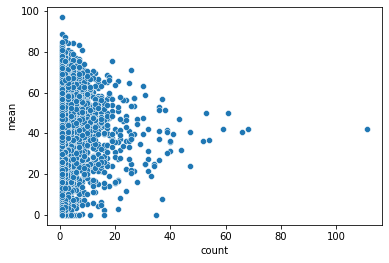

In [130]:
sns.scatterplot(data = artist_df, x = 'count', y = 'mean')

In [133]:
artist_df.sort_values(by = 'mean', ascending=False).head(20)

,track_artist,count,mean,median
8461,Trevor Daniel,1.0,97.000000,97.0
490,Ant Saunders,1.0,89.000000,89.0
2248,Don Toliver,2.0,87.500000,87.5
4381,Kina,2.0,85.500000,85.5
6364,Pedro Sampaio,1.0,85.000000,85.0
1903,DaBaby,5.0,84.600000,87.0
3627,JACKBOYS,3.0,84.333333,84.0
1910,Dadá Boladão,1.0,84.000000,84.0
6914,Roddy Ricch,7.0,83.428571,81.0
2033,Dayvi,1.0,83.000000,83.0


## 4.2. Features Engineering

In [120]:
# Artist
def label_pop(score):
    if score < 30:
        return "very popular"
    if (score >= 30) & (score <=60):
        return "quite popular"
    if score > 60:
        return "less popular"
artist_df = df.groupby('track_artist').agg({'track_popularity': 'mean'}).reset_index()
artist_df['artist_label'] = artist_df['track_popularity'].apply(lambda x: label_pop(x))

In [121]:
df_1 = pd.merge(df, artist_df.drop(['track_popularity'], axis = 1), on = 'track_artist', how = 'left')
df_1.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,artist_label
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754,less popular
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600,quite popular
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616,quite popular
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093,quite popular
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052,less popular


In [122]:
# subgenre
subgenre_df = df.groupby('playlist_subgenre').agg({'track_popularity': 'mean'}).reset_index()
def label_pop(score):
    if score < 30:
        return "very popular"
    if (score >= 30) & (score <=60):
        return "quite popular"
    if score > 60:
        return "less popular"
subgenre_df['subgenre_label'] = subgenre_df['track_popularity'].apply(lambda x: label_pop(x))

df_1 = pd.merge(df_1, subgenre_df.drop(['track_popularity'], axis = 1), on = 'playlist_subgenre', how = 'left')
df_1.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,artist_label,subgenre_label
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754,less popular,quite popular
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600,quite popular,quite popular
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616,quite popular,quite popular
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093,quite popular,quite popular
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052,less popular,quite popular


In [123]:
corr_num_cols = list(filter(lambda x: x!= 'track_popularity', correlated_cols))  # replaced by popularity_label
cate_cols = ['artist_label', 'playlist_genre', 'subgenre_label']
class_col = ['popularity_label']

chosen_features = corr_num_cols + cate_cols + class_col
df_modeling = df_1[chosen_features]

KeyError: "['track_album_release_year', 'release_days', 'popularity_label'] not in index"

In [ ]:
# encoding categorical cols
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
for col in (cate_cols + class_col):
    encoder.fit(df_modeling[col])
    df_modeling[col] = encoder.transform(df_modeling[col])

## 4.3. Set up model

In [ ]:
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
# model = RandomForestClassifier(random_state = 2)

In [ ]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(
                            df_modeling.loc[:, df_modeling.columns != 'popularity_label'], 
                            df_modeling['popularity_label'], 
                                        train_size = 0.75, random_state = 5
                                        )

In [ ]:
rand = [11,16,12,17,19]
re = []
for r in rand:
    X_train, X_test, y_train, y_test = train_test_split(
                            df_modeling.loc[:, df_modeling.columns != 'popularity_label'], 
                            df_modeling['popularity_label'], 
                                        train_size = 0.75, random_state = r
                                        )
    model = RandomForestClassifier(random_state = 2)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    re.append(metrics.accuracy_score(y_test, y_pred))

In [ ]:
re

In [ ]:
# XGB
metrics.confusion_matrix(y_test, y_pred)

In [ ]:
# RF
metrics.confusion_matrix(y_test, y_pred)

## 4.1. Very first: Default Linear Regression- no feature engineering

In [ ]:
X = num_df[num_df.columns[1:]]
y = num_df[num_df.columns[0]]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)

linear = LinearRegression().fit(X_train, y_train)
pred = linear.predict(X_test)

mae = metrics.mean_absolute_error(y_test, pred)
rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))
r2_score = metrics.r2_score(y_test, pred)

print(mae)
print(rmse)

results_update('LR - Keep default all', mae, rmse)

In [ ]:
compare_table = pd.DataFrame({'true': y_test,
                              'prediction' : pred})

compare_table = compare_table.reset_index(drop = True)

fig, axe = plt.subplots(1,1,figsize=(20,10))
sub_data = compare_table.iloc[200:300]
sns.lineplot(x = sub_data.index, y = sub_data.true)
sns.lineplot(x = sub_data.index, y = sub_data.prediction, color = 'red')

The model is not good even on train set.

## 4.2. FE: add year

In [ ]:
spotify_df['track_release_year'] = spotify_df['track_album_release_date'].apply(lambda x: int(x.year))

In [ ]:
spotify_df = spotify_df.drop(columns = ['lenth_date'])

In [ ]:
num_vars = [spotify_df.columns[3]] + spotify_df.columns[11:].to_list() 
num_df = spotify_df[num_vars]

In [ ]:
num_df

In [ ]:
X = num_df[num_df.columns[1:]]
y = num_df[num_df.columns[0]]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)

linear = LinearRegression().fit(X_train, y_train)
pred = linear.predict(X_test)

mae = metrics.mean_absolute_error(y_test, pred)
rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))

print(mae)
print(rmse)

results_update('LR - Add year', mae, rmse)

In [ ]:
X_train

## 4.3. Remove popularity <= 10

In [ ]:
num_df.columns

In [ ]:
num_vars = [spotify_df.columns[3]] + spotify_df.columns[11:].to_list()
num_df = spotify_df[num_vars]
high_popular_df = num_df.loc[num_df.track_popularity >= 10]

In [ ]:
# re-check distribution of popularity after remove outliers < 10
fig, ax = plt.subplots(1,1,figsize=(20,6))
ax.hist(high_popular_df['track_popularity'], bins = 30)

In [ ]:
X = high_popular_df[high_popular_df.columns[1:]]
y = high_popular_df[high_popular_df.columns[0]]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)
linear = LinearRegression().fit(X_train, y_train)
pred = linear.predict(X_test)
mae = metrics.mean_absolute_error(y_test, pred)
mrse = np.sqrt(metrics.mean_squared_error(y_test, pred))

results_update('Remove popularity < 10', mae, mrse)

Model performs well on high distribution range of popularity, very low at 2 tails

## 4.4. Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
def process_and_predict(df, algo):
    X = df[df.columns[1:]]
    y = df[df.columns[0]]

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)
    model = algo.fit(X_train, y_train)
    pred = model.predict(X_test)
    mae = metrics.mean_absolute_error(y_test, pred)
    mrse = np.sqrt(metrics.mean_squared_error(y_test, pred))
    return mae, mrse, pred

In [ ]:
# TRY ON BOTH TRAIN AND TEST SET
accuracy_table = pd.DataFrame(columns = ['min_samples', 'mae_train', 'mrse_train', 'mae_test', 'mrse_test'])

def accuracy_plot(eval_set, min_split, min_leaf):
    algo_ = DecisionTreeRegressor(min_samples_split = min_split, min_samples_leaf = min_leaf)
    
    X = high_popular_df[high_popular_df.columns[1:]]
    y = high_popular_df[high_popular_df.columns[0]]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)
    model = algo_.fit(X_train, y_train)
    pred_test = model.predict(X_test)
    mae_test = metrics.mean_absolute_error(y_test, pred_test)
    mrse_test = np.sqrt(metrics.mean_squared_error(y_test, pred_test))
    
    pred_train = model.predict(X_train)
    mae_train = metrics.mean_absolute_error(y_train, pred_train)
    mrse_train = np.sqrt(metrics.mean_squared_error(y_train, pred_train))
    
    return mae_train, mrse_train, mae_test, mrse_test, pred_test, pred_train #5

for num in range(10,200,10):
    acc = accuracy_plot(num, 1)
    accuracy_table.loc[len(accuracy_table)] = [num, acc[0], acc[1], acc[2], acc[3]]
    
accuracy_table

In [ ]:
accuracy_table = pd.DataFrame(columns = ['min_samples', 'mae_train', 'mrse_train', 'mae_test', 'mrse_test'])

for num in range(10,200,10):
    acc = accuracy_plot(num, 5)
    accuracy_table.loc[len(accuracy_table)] = [num, acc[0], acc[1], acc[2], acc[3]]
    
accuracy_table

In [ ]:
# TEMP CHECK ON TEST SET
print(process_and_predict(high_popular_df, algo_)[0])
print(process_and_predict(high_popular_df, algo_)[1])

- The result of DT Regressor is very good at Train Set
- The result of Test Set is more good when modify params: min_samples_split increases

In [ ]:
algo_.

In [ ]:
# features importance
# feature_importances_
algo_ = DecisionTreeRegressor().fit(X_train, y_train)
fea_imp = pd.DataFrame({'col': algo_.feature_names_in_,
                        'imp_score': algo_.feature_importances_})
fea_imp

In [ ]:
not_mode_and_key = high_popular_df.drop(columns = ['mode', 'key', 'track_release_year'])
not_mode_and_key.columns

In [ ]:
# TEST TREE WITH REMOVED USELESS FEATURES
all_feas = process_and_predict(high_popular_df, RandomForestRegressor(min_samples_split = 50))
mode_key_removed = process_and_predict(not_mode_and_key, RandomForestRegressor(min_samples_split = 50))
print(all_feas[0], all_feas[1])
print(mode_key_removed[0], mode_key_removed[1])

In [ ]:
result = process_and_predict(high_popular_df, DecisionTreeRegressor(min_samples_split = 200))
results_update("DTreeRegressor - Remove popularity < 10 - Min Samples 800", result[0], result[1])

In [ ]:
def result_plot(y_test, pred, index_start, index_end):
    compare_table = pd.DataFrame({'true': y_test,
                                  'prediction' : pred})

    compare_table = compare_table.reset_index(drop = True)

    fig, axe = plt.subplots(1,1,figsize=(20,10))
    sub_data = compare_table.iloc[int(index_start):int(index_end)]
    sns.lineplot(x = sub_data.index, y = sub_data.true)
    sns.lineplot(x = sub_data.index, y = sub_data.prediction, color = 'red')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)
result_plot(y_train, accuracy_plot(20, 20)[5], 200, 400)

## 4.5. Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
def accuracy_plot(min_split, min_leaf):
    algo_ = RandomForestRegressor(min_samples_split = min_split, min_samples_leaf = min_leaf)
    
    X = high_popular_df[high_popular_df.columns[1:]]
    y = high_popular_df[high_popular_df.columns[0]]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)
    model = algo_.fit(X_train, y_train)
    pred_test = model.predict(X_test)
    mae_test = metrics.mean_absolute_error(y_test, pred_test)
    mrse_test = np.sqrt(metrics.mean_squared_error(y_test, pred_test))
    
    pred_train = model.predict(X_train)
    mae_train = metrics.mean_absolute_error(y_train, pred_train)
    mrse_train = np.sqrt(metrics.mean_squared_error(y_train, pred_train))
    
    return mae_train, mrse_train, mae_test, mrse_test, pred_test, pred_train #5


accuracy_table = pd.DataFrame(columns = ['min_samples', 'mae_train', 'mrse_train', 'mae_test', 'mrse_test'])

for num in range(2,11,1):
    acc = accuracy_plot(num, 1)
    accuracy_table.loc[len(accuracy_table)] = [num, acc[0], acc[1], acc[2], acc[3]]
    
accuracy_table

In [ ]:
acc = accuracy_plot(2, 1)
print(acc[2])
print(acc[3])

In [ ]:
start = datetime.datetime.now()
forest = RandomForestRegressor().fit(X_train, y_train)

stop = datetime.datetime.now()
# forest_pred = forest.predict()
print((stop - start).seconds)

In [ ]:
forest_pred= default.predict(X_test)
metrics.mean_absolute_error(y_test, forest_pred)
np.sqrt(metrics.mean_squared_error(y_test, forest_pred))

In [ ]:
result_plot(y_test, def_pred, 300, 350)

## 4.6. Gradient Boost

In [ ]:
boost = sklearn.ensemble.GradientBoostingRegressor()
boost.fit(X_train, y_train)
boost_pred = boost.predict(X_test)

In [ ]:
metrics.mean_absolute_error(y_test, boost_pred)
np.sqrt(metrics.mean_squared_error(y_test, boost_pred))

In [ ]:
result_plot(y_test, def_pred, 300, 350)

In [ ]:
result_plot(y_test, boost_pred, 300, 350)

## 4.5. Neural Network Regression

In [ ]:
from sklearn.neural_network import MLPRegressor

In [ ]:
nn_result = process_and_predict(high_popular_df, MLPRegressor())
results_update('NN - Remove popularity < 10', nn_result[0], nn_result[1])

In [ ]:
compare_table = pd.DataFrame({'true': y_test,
                              'prediction' : nn_result[2]})

compare_table = compare_table.reset_index(drop = True)

fig, axe = plt.subplots(1,1,figsize=(20,10))
sub_data = compare_table.iloc[200:300]
sns.lineplot(x = sub_data.index, y = sub_data.true)
sns.lineplot(x = sub_data.index, y = sub_data.prediction, color = 'red')

In [ ]:
poly_model = poly.fit(new_X, y)

In [ ]:
poly.get_params

In [ ]:
a = pd.DataFrame({'true': y_test,  
                  'pred' : forest_pred})

# b = a.loc[a.true <= 80]
# np.sqrt(metrics.mean_squared_error(b['true'], b['pred']))
# popular_more_80 = spotify_df.loc[spotify_df.track_popularity >= 80].sort_values(by = 'track_popularity', ascending = False)
a.to_csv('default_forest_prediction.csv', index = False)